# Hate Speech Detection with RoBERTa, Adversarial Training (FGM), and Explainability

This notebook implements a hate speech/offensive language detection model based on the project proposal. It fine-tunes a pre-trained BERT model using PyTorch, incorporating:

1.  **Data Loading & Preprocessing:** Handles TXT and TSV/CSV files, basic text cleaning, and preparation for BERT.
2.  **RoBERTa Fine-tuning:** Uses a Hugging Face Transformer called RoBERTa for twitter comments for model loading and training.
3.  **Adversarial Training:** Implements the Fast Gradient Method (FGM) on embeddings as a technique to improve robustness.
4.  **Evaluation:** Calculates standard classification metrics (Accuracy, F1, Precision, Recall) and generates reports/visualizations.
5.  **Explainability:** Provides basic attention visualization to understand model focus.
6.  **Configuration:** Key parameters are set in a dedicated cell for easy experimentation.
7.  **Early Stopping:** Optional mechanism to prevent overfitting.
8.  **Artifact Saving:** Saves the trained model, tokenizer, results, and plots.

## 1. Setup and Imports

Import necessary libraries and set up basic configurations.

In [71]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Avoids warning from HuggingFace transformers
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"  # Mitigate fragmentation

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.optim import AdamW

import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import json
import time
import random
from copy import deepcopy
from typing import Dict, List, Tuple, Optional
from tqdm.auto import tqdm
import re, html
import wandb
import emoji

## 2. Configuration

Set hyperparameters, file paths, model name, and feature flags here. Adjust these values for your specific dataset and experiments.

In [111]:
# --- Core Configuration ---

MODEL_NAME = 'cardiffnlp/twitter-roberta-base'
MAX_LEN = 128  # Max sequence length for RoBERTa tokenizer
BATCH_SIZE = 16 # Reduce if facing GPU memory issues
EPOCHS = 5     # Number of training epochs
LEARNING_RATE = 2e-5 # Standard learning rate for BERT fine-tuning
SEED = 42      # Random seed for reproducibility
OUTPUT_DIR = 'model_output' # Directory to save model, results, plots
WARMUP_RATIO = 0.12 # Proportion of training steps to use for warmup
WEIGHT_DECAY = 0.02 # Weight decay for AdamW optimizer
VAL_SPLIT_SIZE = 0.15 # Proportion of training data to use for validation

# --- Feature Flags ---
USE_FGM = True # Set to True to enable Fast Gradient Method adversarial training
# USE_PGD = False # Set to True to enable Projected Gradient Descent adversarial training
ADVERSARIAL_EPS = 0.1 # Epsilon for FGM perturbation (if USE_FGM is True)
# PGD_EPS = 0.05 # Epsilon for PGD perturbation (if USE_PGD is True)
# PGD_K = 3 # Number of steps for PGD perturbation (if USE_PGD is True)
USE_EARLY_STOPPING = True # Set to True to enable early stopping
PATIENCE = 2 # Number of epochs to wait for improvement before stopping (if USE_EARLY_STOPPING is True)
ACCUMULATION_STEPS = 2 # Or 4, effectively making batch size BATCH_SIZE * ACCUMULATION_STEPS

# --- Dataset Configuration ---
BASE_DIR = os.getcwd()
print("Base dir:", BASE_DIR)
# Choose one dataset type to configure
DATASET_TYPE = 'HASOC' # Options: 'OLID', 'HASOC', 'OffenseEval'
# For OLID & OffenseEval use 'a','b','c'; for HASOC use '1','2','3'
SUBTASK = '3'        # e.g. HASOC subtask 1 (task_1), 2 (task_2), or 3 (task_3)


# --- File paths ---
if DATASET_TYPE == 'OLID':
    DATA_DIR   = os.path.join(BASE_DIR, 'OlidPreprcessed')
    TRAIN_FILE = os.path.join(DATA_DIR, 'OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt')
    print(f"Train file: {TRAIN_FILE}")
    
    # pick the right test file for a, b or c
    TEST_FILE  = os.path.join(
        DATA_DIR,
        f'OLID_TEST_{SUBTASK.upper()}_ATUSER_URL_EmojiRemoved_Pedro.txt'
    )
    print(f"Test file: {TEST_FILE}")
    TEST_LABELS_FILE = None
    TEXT_COLUMN = 'tweet'
    
    # label column + map per subtask
    LABEL_COLUMN = f'subtask_{SUBTASK.lower()}'
    if SUBTASK == 'a':
        LABEL_MAP = {'NOT': 0, 'OFF': 1}
    elif SUBTASK == 'b':
        LABEL_MAP = {'UNT': 0, 'TIN': 1}
    else:  # c
        LABEL_MAP = {'IND': 0, 'GRP': 1, 'OTH': 2}
    NUM_LABELS = len(LABEL_MAP)


elif DATASET_TYPE == 'HASOC':
    # include the Project_folder in path
    DATA_DIR    = os.path.join(BASE_DIR, 'HASOCData')
    TRAIN_FILE  = os.path.join(DATA_DIR, 'english_dataset.tsv')
    print(f"Train file: {TRAIN_FILE}")
    TEST_FILE   = os.path.join(DATA_DIR, 'hasoc2019_en_test-2919.tsv')
    TEST_LABELS_FILE = None

    TEXT_COLUMN  = 'tweet'
    LABEL_COLUMN = f'task_{SUBTASK}'
    if SUBTASK == '1':
        LABEL_MAP = {'NOT': 0, 'HOF': 1}
    elif SUBTASK == '2':
        LABEL_MAP = {'HATE': 0, 'OFFN': 1, 'PRFN': 2}
    else:  # '3'
        LABEL_MAP = {'UNT': 0, 'TIN': 1}
    NUM_LABELS = len(LABEL_MAP)


elif DATASET_TYPE == 'OffenseEval':
    DATA_DIR = os.path.join(BASE_DIR, 'OffenseEval')
    # Train: all nine parts for subtask A, or distant files for B/C
    if SUBTASK == 'a':
        part_paths = [os.path.join(DATA_DIR, f'task_a_part{i}.xlsx') for i in range(1, 10)]
        # load & concat all parts:
        TRAIN_FILE = None
        train_dfs = [pd.read_excel(p) for p in part_paths if os.path.exists(p)]
        df_train_all = pd.concat(train_dfs, ignore_index=True)
    elif SUBTASK == 'b':
        TRAIN_FILE = os.path.join(DATA_DIR, 'task_b_distant.xlsx')
    else:  # 'c'
        TRAIN_FILE = os.path.join(DATA_DIR, 'task_c_distant_ann.xlsx')

    TEST_DIR = DATA_DIR
    TEST_FILE = os.path.join(TEST_DIR, f'test_{SUBTASK}.tsv')  # or whatever your naming is
    TEST_LABELS_FILE = None

    TEXT_COLUMN  = 'tweet'
    LABEL_COLUMN = f'subtask_{SUBTASK}'
    if SUBTASK == 'a':
        LABEL_MAP = {'NOT': 0, 'OFF': 1}
    elif SUBTASK == 'b':
        LABEL_MAP = {'UNT': 0, 'TIN': 1}
    else:  # 'c'
        LABEL_MAP = {'IND': 0, 'GRP': 1, 'OTH': 2}
    NUM_LABELS = len(LABEL_MAP)

else:
    raise ValueError("Invalid DATASET_TYPE. Choose from 'OLID', 'HASOC', 'OffenseEval'.")


# --- Create output directory ---
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Save Configuration to JSON (for record keeping) ---
config_dict = {
    'MODEL_NAME': MODEL_NAME,
    'MAX_LEN': MAX_LEN,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'LEARNING_RATE': LEARNING_RATE,
    'WARMUP_RATIO': WARMUP_RATIO,
    'WEIGHT_DECAY': WEIGHT_DECAY,
    'SEED': SEED,
    'OUTPUT_DIR': OUTPUT_DIR,
    'DATASET_TYPE': DATASET_TYPE,
    'BASE_DIR': BASE_DIR,
    'TRAIN_FILE': locals().get('TRAIN_FILE'),
    'TEST_FILE': locals().get('TEST_FILE'),
    'TEST_LABELS_FILE': TEST_LABELS_FILE,
    'TEXT_COLUMN': TEXT_COLUMN,
    'LABEL_COLUMN': LABEL_COLUMN,
    'LABEL_MAP': LABEL_MAP,
    'NUM_LABELS': NUM_LABELS,
    'VAL_SPLIT_SIZE': VAL_SPLIT_SIZE,
    'USE_FGM': USE_FGM,
    'ADVERSARIAL_EPS': ADVERSARIAL_EPS if USE_FGM else None,
    'USE_EARLY_STOPPING': USE_EARLY_STOPPING,
    'PATIENCE': PATIENCE if USE_EARLY_STOPPING else None
}

config_filename = f"config_{DATASET_TYPE}.json"
config_path     = os.path.join(OUTPUT_DIR, config_filename)
with open(config_path, 'w') as f:
    json.dump(config_dict, f, indent=4)

print(f"Configuration saved to {config_path}")

Base dir: /
Train file: /HASOCData/english_dataset.tsv
Configuration saved to model_output/config_HASOC.json


## 3. Environment Setup

Set random seeds for reproducibility and select the compute device (GPU if available, otherwise CPU).

In [92]:
def set_seed(seed_value: int):
    """Sets the seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        # These two lines are for deterministic behavior, can slightly slow down training
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False
set_seed(SEED)

# Select device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('Using CPU')

Using GPU: NVIDIA GeForce RTX 2080 Ti


## 4. Tokenizer Initialization
Initialize the tokenizer globally here, now that the env var is set and transformers is imported.

In [112]:
print(f"Loading tokenizer for model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer loaded: {tokenizer}")

Loading tokenizer for model: cardiffnlp/twitter-roberta-base
Tokenizer loaded: RobertaTokenizerFast(name_or_path='cardiffnlp/twitter-roberta-base', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=Fa

## 5. Data Loading and Preprocessing Functions

Load data from files, perform basic cleaning, map labels, and split into train/validation/test sets.

In [113]:
def preprocess_text(text: str) -> str:
    """Expanded text cleaning: contractions, mentions, URLs, emojis, HTML, hashtags."""
    # 1) Lowercase & cast
    text = str(text).lower()

    # 2) Contractions
    contractions = {
        r"\bcan't\b": "can not",
        r"\bdon't\b": "do not",
        r"\bit's\b":   "it is",
        r"\bi'm\b":    "i am",
        r"\bwe're\b":  "we are",
        r"\byou're\b": "you are",
        r"\bthey're\b":"they are",
        r"\bhe's\b":   "he is",
        r"\bshe's\b":  "she is",
        r"\bwon't\b":  "will not",
        r"\bwouldn't\b":"would not",
        r"\bshouldn't\b":"should not",
        r"\bhasn't\b": "has not",
        r"\bhaven't\b":"have not",
        r"\bhadn't\b": "had not",
        r"\bdoesn't\b":"does not",
        r"\bdidn't\b": "did not",
        r"\bwasn't\b": "was not",
        r"\bwhat's\b": "what is",
        r"\bwhere's\b": "where is",
        r"\bwho's\b": "who is",
        r"\bthere's\b": "there is",
        r"\blet's\b": "let us",
        r"\bthat's\b": "that is",
        r"\bwho've\b": "who have",
        r"\bwho'll\b": "who will",
        r"\bwho'd\b": "who would",
    }

    for pat, rep in contractions.items():
        text = re.sub(pat, rep, text)

    # 3) Replace user mentions and URLs
    text = re.sub(r'@\w+', '@user', text)                   # unify mentions
    text = re.sub(r'http\S+|www\.\S+', 'httpurl', text)     # unify URLs

    # 4) Decode HTML entities (&amp; → &, &quot; → ")
    text = html.unescape(text)

    # 5) Reduce any character repeated 3+ times down to exactly 2
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # 6) Remove '#' from hashtags but keep the tag text
    text = re.sub(r'#(\w+)', r'\1', text)

    # 7) Convert emojis to words:
    #    - demojize produces e.g. ":smiling_face_with_smiling_eyes:"
    #    - replace ALL colons with spaces => ensures words are separated
    demoj = emoji.demojize(text)
    demoj = demoj.replace(':', ' ')     # ":thumbs_up:" → " thumbs_up "
    demoj = demoj.replace('_', ' ')     # "thumbs_up" → "thumbs up"
    text = demoj

    # 8) Normalize whitespace (collapse runs, strip ends)
    text = re.sub(r'\s+', ' ', text).strip()

    # 9) Remove any *single* '!' immediately followed by space (keep "!!")
    text = re.sub(r'(?<!!)\!(?=\s)', '', text)

    # 10) Remove spaces before punctuation to re-attach them
    text = re.sub(r'\s+([.,!?"])', r'\1', text)

    return text


# --- Data Loading Function ---
# Cell 3: Robust file loading + tests
def load_data(file_path: str, sep: str = '\t') -> Optional[pd.DataFrame]:
    """Load a TSV or CSV file, falling back if necessary."""
    print(f"Loading {file_path!r} (sep='{sep}')…")
    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        return None

    try:
        df = pd.read_csv(file_path, sep=sep, quoting=3, on_bad_lines='warn')
        print(f"✔️ Loaded with sep='{sep}', shape={df.shape}")
        return df
    except Exception as e:
        print(f"⚠️ Failed with sep='{sep}': {e}")

    if sep == '\t':
        print("→ Retrying with sep=','…")
        try:
            df = pd.read_csv(file_path, on_bad_lines='warn')
            print(f"✔️ Loaded with sep=',', shape={df.shape}")
            return df
        except Exception as e2:
            print(f"❌ Still failed: {e2}")

    return None

In [114]:
# --- Data Loading and Preprocessing Function ---
def load_and_preprocess_data(
    train_path: str,
    test_path: str,
    text_col: str,
    label_col: str,
    label_map: Dict[str, int],
    test_labels_path: Optional[str] = None,  # now used
    val_split: float = 0.1,
    seed: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]:

    # --- 1. Load train and test raw DataFrames ---
    df_train = pd.read_csv(train_path, sep='\t', dtype=str)
    df_test  = pd.read_csv(test_path,  sep='\t', dtype=str)

    # 1b) If an external labels file exists, merge it in
    if test_labels_path:
        df_labels = pd.read_csv(test_labels_path, sep='\t', dtype=str)
        # assume both have an “id” column to join on
        df_test = df_test.merge(df_labels[['id', label_col]], on='id', how='left')

    # --- 2. Filter & map train labels ---
    df_train = df_train[df_train[label_col].isin(label_map)].copy()
    df_train['label'] = df_train[label_col].map(label_map).astype(int)

    # --- 3. Clean text & drop empties ---
    df_train['clean_text'] = df_train[text_col].map(preprocess_text)
    before = len(df_train)
    df_train = df_train[df_train['clean_text'].str.len().gt(0)]
    print(f"\nDropped {before - len(df_train)} empty/invalid train rows")

    # --- 4. Process test similarly ---
    df_test['clean_text'] = df_test[text_col].map(preprocess_text)
    if label_col in df_test.columns:
        df_test = df_test[df_test[label_col].isin(label_map)].copy()
        df_test['label'] = df_test[label_col].map(label_map).astype(int)
    before_test = len(df_test)
    df_test = df_test[df_test['clean_text'].str.len().gt(0)]
    print(f"Dropped {before_test - len(df_test)} empty/invalid test rows")

    # --- 5. Stratified train/val split ---
    df_tr, df_val = train_test_split(
        df_train[['clean_text','label']],
        test_size=val_split,
        stratify=df_train['label'],
        random_state=seed
    )
    return df_tr.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)


In [115]:
# --- Execute Data Loading and Preprocessing ---
print("Loading and preprocessing data…")
df_train, df_val, df_test = load_and_preprocess_data(
    train_path       = TRAIN_FILE,
    test_path        = TEST_FILE,
    text_col         = TEXT_COLUMN,
    label_col        = LABEL_COLUMN,
    label_map        = LABEL_MAP,
    test_labels_path = TEST_LABELS_FILE,
    val_split        = VAL_SPLIT_SIZE,
    seed             = SEED
)

print(f"\nTrain: {len(df_train)} rows; Val: {len(df_val)} rows; "
      f"Test: {len(df_test) if df_test is not None else 'N/A'}")

print("Train label dist:\n", df_train['label'].value_counts(normalize=True))
print("Val   label dist:\n", df_val['label'].value_counts(normalize=True))
if df_test is not None and 'label' in df_test.columns:
    print("Test  label dist:\n", df_test['label'].value_counts(normalize=True))
else:
    print("Test  label dist:\n N/A (test set unlabeled)")

Loading and preprocessing data…

Dropped 0 empty/invalid train rows
Dropped 0 empty/invalid test rows

Train: 1921 rows; Val: 340 rows; Test: 288
Train label dist:
 label
1    0.902655
0    0.097345
Name: proportion, dtype: float64
Val   label dist:
 label
1    0.902941
0    0.097059
Name: proportion, dtype: float64
Test  label dist:
 label
1    0.850694
0    0.149306
Name: proportion, dtype: float64


## 6. PyTorch Dataset and DataLoader

Create a custom PyTorch `Dataset` to handle text tokenization on-the-fly and `DataLoader` for batching.

In [116]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts     = texts
        self.labels    = labels
        self.tokenizer = tokenizer
        self.max_len   = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        enc  = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        if self.labels is not None:
            # return label as long for CrossEntropyLoss
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# --- Improved DataLoaders ---
num_workers = min(2, os.cpu_count() or 1)  # cap at 2
pin_memory  = torch.cuda.is_available()

# --- Create train/val datasets & loaders ---
train_dataset = TextClassificationDataset(
    texts=df_train['clean_text'].tolist(),
    labels=df_train['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
val_dataset = TextClassificationDataset(
    texts=df_val['clean_text'].tolist(),
    labels=df_val['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    prefetch_factor=2            # start loading next batches early
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

print(f"▶️ Train loader: {len(train_dataset)} samples")
print(f"▶️ Val   loader: {len(val_dataset)} samples")

# --- Create test loader only if 'label' exists ---
test_loader = None
if df_test is not None and 'label' in df_test.columns and len(df_test) > 0:
    test_dataset = TextClassificationDataset(
        texts=df_test['clean_text'].tolist(),
        labels=df_test['label'].tolist(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    print(f"▶️ Test  loader: {len(test_dataset)} samples")
else:
    print("ℹ️ No labeled test set found → skipping test DataLoader")

▶️ Train loader: 1921 samples
▶️ Val   loader: 340 samples
▶️ Test  loader: 288 samples


## 7. Model Loading

Load the pre-trained BERT model for sequence classification.

In [117]:
print(f"Loading pre-trained model: {MODEL_NAME}")
try:
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS, # Binary classification
        output_attentions=True, # We need explainability later after training
    )
except Exception as e:
    raise SystemExit(f"Failed to load model {MODEL_NAME}: {e}. Check model name and internet connection.")

# Move model to the appropriate device
model.to(device)
print("Model loaded and moved to device.")

Loading pre-trained model: cardiffnlp/twitter-roberta-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to device.


## 8. Adversarial Training (FGM & PGD)

Define the Fast Gradient Method (FGM) to perturb word embeddings during training. This is applied only if `USE_FGM` is `True`.

In [118]:
class FGM:
    """
    Fast Gradient Method: a single-step epsilon perturbation on embeddings.
    """
    def __init__(self, model: nn.Module, emb_name: str, epsilon: float = 0.1):
        self.model = model
        self.epsilon = epsilon
        self.emb_name = emb_name # Store the target embedding name pattern
        self.backup = {}
        self.emb_param_name = None
        self.emb_param = None

        # Find the embedding parameter
        for name, param in model.named_parameters():
            if self.emb_name in name:
                self.emb_param_name = name
                self.emb_param = param
                print(f"FGM: Found embedding layer: {self.emb_param_name}")
                break
        if self.emb_param is None:
            raise ValueError(f"Embedding parameter containing '{self.emb_name}' not found in the model.")

    def attack(self):
        # Ensure gradients exist and are finite
        if self.emb_param is None or self.emb_param.grad is None or not torch.isfinite(self.emb_param.grad).all():
            # print("FGM attack: grad is None or not finite, skipping attack.")
            return

        self.backup[self.emb_param_name] = self.emb_param.data.clone() # Backup original data
        grad = self.emb_param.grad.data # Use .data to avoid issues with graph
        
        norm = torch.norm(grad)
        if norm != 0 and not torch.isnan(norm):
            r_at = self.epsilon * grad / norm
            self.emb_param.data.add_(r_at)
        # else:
            # print(f"FGM attack: norm is {norm}, skipping perturbation.")

    def restore(self):
        if self.emb_param_name in self.backup:
            self.emb_param.data = self.backup[self.emb_param_name]
        self.backup.clear()

### Adversarial Training Initialization

In [119]:
fgm_instance = None
if USE_FGM:
    print("Initializing FGM adversarial trainer…")
    # For RoBERTa-like models, the word embeddings are typically within 'roberta.embeddings.word_embeddings.weight'
    embedding_name_for_adv = 'roberta.embeddings.word_embeddings.weight'
    try:
        fgm_instance = FGM(
            model,
            emb_name=embedding_name_for_adv,
            epsilon=ADVERSARIAL_EPS
        )
        print(f"  FGM ready (ε={fgm_instance.epsilon})")
    except Exception as e:
        print(f"❌ FGM init failed: {e}. Disabling FGM.")
        USE_FGM = False
else:
    print("No FGM adversarial training will be applied.")

Initializing FGM adversarial trainer…
FGM: Found embedding layer: roberta.embeddings.word_embeddings.weight
  FGM ready (ε=0.1)


## 9. Training Loop

Define functions for a single training epoch and evaluation, then implement the main training loop.

## Training Loop Functions

In [120]:
# --- Training Loop ---
def train_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    use_fgm: bool,
    fgm_instance: Optional[FGM],
    scaler: GradScaler, # Pass scaler
    accumulation_steps: int = 1
):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    if accumulation_steps > 1:
        optimizer.zero_grad(set_to_none=True)

    for i, batch in enumerate(tqdm(data_loader, desc="Training", unit="batch", leave=False)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        batch_size = input_ids.size(0)

        if accumulation_steps == 1 or (i % accumulation_steps == 0) :
            optimizer.zero_grad(set_to_none=True)

        # --- Standard Forward Pass ---
        with autocast(device_type=device.type, enabled=device.type == 'cuda'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            if accumulation_steps > 1:
                loss = loss / accumulation_steps
        
        # --- Backward Pass for Main Loss (and FGM if active) ---
        # Scale loss and backward pass.
        # If FGM is used, retain_graph=True is needed so FGM can use the gradients
        # from this pass to calculate perturbations.
        scaler.scale(loss).backward(retain_graph=True if use_fgm and fgm_instance else False)

        # --- FGM Adversarial Step ---
        if use_fgm and fgm_instance:
            # emb_param.grad should now be populated from the backward pass above.
            fgm_instance.attack()  # Perturb embeddings

            # Zero gradients for the model parameters (not necessarily embeddings if FGM internally handles it)
            # before the adversarial forward/backward.
            # However, for FGM, typically the adversarial loss is added to the main loss,
            # or a separate backward pass is done for the adversarial loss, and gradients accumulate.
            # Here, we'll do a separate backward pass for the adversarial loss.
            # It's important that emb_param.grad is NOT zeroed before fgm_instance.attack() if it relies on it.
            # And it's also important that the optimizer's gradients are zeroed before this new backward pass if we are not accumulating.
            # Since we're using a scaler, it manages gradient accumulation.
            # The scaler.scale(adv_loss).backward() will add to the existing gradients.
            
            # If we are accumulating, we should only zero_grad for the parameters (not embeddings for the attack itself)
            # at the beginning of the accumulation cycle.
            # For FGM, the attack uses the *current* gradients. The previous `loss.backward()` populated them.
            
            # We need to zero gradients for parameters before the adversarial backward pass if not accumulating
            # OR if this is the first step in an accumulation block.
            # Let's ensure gradients for the adversarial loss are computed cleanly.
            if accumulation_steps == 1 : # If not accumulating, zero grads before each adv step
                 optimizer.zero_grad(set_to_none=True) 
                 # Re-do the clean pass backward to get fresh grads for FGM attack
                 # This is less efficient but safer if FGM re-uses the model's .grad attributes
                 with autocast(device_type=device.type, enabled=device.type == 'cuda'):
                     clean_outputs_for_fgm = model(input_ids=input_ids, attention_mask=attention_mask)
                     clean_loss_for_fgm = loss_fn(clean_outputs_for_fgm.logits, labels)
                     if accumulation_steps > 1:
                         clean_loss_for_fgm = clean_loss_for_fgm / accumulation_steps
                 scaler.scale(clean_loss_for_fgm).backward(retain_graph=True) # Retain for attack
                 fgm_instance.attack() # Attack based on fresh clean gradients

            with autocast(device_type=device.type, enabled=device.type == 'cuda'):
                adv_outputs = model(input_ids=input_ids, attention_mask=attention_mask) # Embeddings are now perturbed
                adv_logits = adv_outputs.logits
                adv_loss = loss_fn(adv_logits, labels)
                if accumulation_steps > 1:
                    adv_loss = adv_loss / accumulation_steps
            
            scaler.scale(adv_loss).backward() # Accumulate gradients from adversarial example
            fgm_instance.restore()  # Restore embeddings
        
        # --- Optimizer Step ---
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(data_loader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step() 
            if accumulation_steps > 1 and (i + 1) != len(data_loader):
                 optimizer.zero_grad(set_to_none=True)


        preds = torch.argmax(logits, dim=1) # Logits from the clean pass
        correct_predictions += torch.sum(preds == labels).item()
        # Log the original (non-adversarial) loss, de-normalized if accumulated
        total_loss += loss.item() * batch_size * (accumulation_steps if accumulation_steps > 1 else 1)
        total_samples += batch_size
        
        # Clean up (optional, but good practice for memory)
        del input_ids, attention_mask, labels, outputs, logits, loss
        if use_fgm and fgm_instance:
            if 'adv_outputs' in locals(): del adv_outputs
            if 'adv_logits' in locals(): del adv_logits
            if 'adv_loss' in locals(): del adv_loss
            if accumulation_steps == 1 and 'clean_outputs_for_fgm' in locals(): del clean_outputs_for_fgm
            if accumulation_steps == 1 and 'clean_loss_for_fgm' in locals(): del clean_loss_for_fgm
        torch.cuda.empty_cache()


    avg_loss = total_loss / total_samples
    avg_acc = correct_predictions / total_samples
    return avg_loss, avg_acc

# --- eval_model (Assuming this function is defined as before) ---
def eval_model( model: nn.Module, data_loader: DataLoader, device: torch.device, loss_fn: nn.Module ):
    model.eval(); total_loss = total_samples = 0; all_preds = []; all_labels = []
    for batch in tqdm(data_loader, desc="Evaluating", unit="batch", leave=False):
        input_ids = batch['input_ids'].to(device); attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device); batch_size = input_ids.size(0)
        with torch.no_grad(): outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits; loss = loss_fn(logits, labels)
        total_loss += loss.item() * batch_size; total_samples+= batch_size
        preds = torch.argmax(logits, dim=1); all_preds.extend(preds.cpu().tolist()); all_labels.extend(labels.cpu().tolist())
    avg_loss = total_loss / total_samples; accuracy  = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    return avg_loss, accuracy, f1, precision, recall, all_labels, all_preds

### Training & Validation Driver

In [121]:
# --- Training & Validation Driver ---
print("Computing class weights…")
# ... (class weight computation as before)
classes = np.unique(df_train['label'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df_train['label'])
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print("Class weights:", dict(zip(classes, weights)))


loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, eps=1e-8)
# ... (scheduler setup as before)
num_training_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(WARMUP_RATIO * num_training_steps),
    num_training_steps=num_training_steps
)


history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
total_training_time_seconds = 0 # Initialize

# Initialize GradScaler ONCE before the loop
scaler = GradScaler(enabled=torch.cuda.is_available())
ACCUMULATION_STEPS = 1 # Set to 1 if not using accumulation, or >1 if gradient accumulation needed


print(f"Starting training for {EPOCHS} epochs…")
training_start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch}/{EPOCHS}")
    
    train_loss, train_acc = train_epoch(
        model, train_loader, loss_fn, optimizer, device,
        scheduler, USE_FGM, fgm_instance,
        scaler, # Pass scaler
        accumulation_steps=ACCUMULATION_STEPS
    )
    print(f"Train → loss: {train_loss:.4f}, acc: {train_acc:.4f}")

    val_loss, val_acc, val_f1, val_prec, val_rec, _, _ = eval_model(
        model, val_loader, device, loss_fn
    )
    print(f"Val   → loss: {val_loss:.4f}, acc: {val_acc:.4f}, f1: {val_f1:.4f}, prec: {val_prec:.4f}, rec: {val_rec:.4f}")

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch # Store the best epoch number
        epochs_no_improve = 0
        best_model_state = model.state_dict().copy() # Make a copy
        print("✔️ New best model saved.")
    else:
        epochs_no_improve += 1
        print(f"⏳ No improvement: {epochs_no_improve}/{PATIENCE}")

    if USE_EARLY_STOPPING and epochs_no_improve >= PATIENCE:
        print("🛑 Early stopping triggered.")
        break
    
    epoch_end_time = time.time()
    print(f"Epoch {epoch} took {epoch_end_time - epoch_start_time:.2f} seconds.")

total_training_time_seconds = time.time() - training_start_time
print(f"\nTotal training time: {total_training_time_seconds:.2f} seconds.")

if best_model_state is not None:
    print(f"\nLoading best model state from epoch {best_epoch} for final evaluation and saving...")
    model.load_state_dict(best_model_state)
else:
    print("\nWarning: No best model state saved. Using final model state.")

print("Training complete.")

Computing class weights…
Class weights: {np.int64(0): np.float64(5.136363636363637), np.int64(1): np.float64(0.553921568627451)}
Starting training for 5 epochs…

Epoch 1/5


Training:   0%|          | 0/121 [00:00<?, ?batch/s]

Train → loss: 0.6792, acc: 0.5809


Evaluating:   0%|          | 0/22 [00:00<?, ?batch/s]

Val   → loss: 0.6552, acc: 0.8118, f1: 0.8363, prec: 0.8722, rec: 0.8118
✔️ New best model saved.
Epoch 1 took 35.28 seconds.

Epoch 2/5


Training:   0%|          | 0/121 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe46415a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Train → loss: 0.5793, acc: 0.8308


Evaluating:   0%|          | 0/22 [00:00<?, ?batch/s]

Val   → loss: 0.5446, acc: 0.8588, f1: 0.8707, prec: 0.8870, rec: 0.8588
✔️ New best model saved.
Epoch 2 took 35.59 seconds.

Epoch 3/5


Training:   0%|          | 0/121 [00:00<?, ?batch/s]

Train → loss: 0.4413, acc: 0.8938


Evaluating:   0%|          | 0/22 [00:00<?, ?batch/s]

Val   → loss: 0.6042, acc: 0.8765, f1: 0.8823, prec: 0.8895, rec: 0.8765
⏳ No improvement: 1/2
Epoch 3 took 45.55 seconds.

Epoch 4/5


Training:   0%|          | 0/121 [00:00<?, ?batch/s]

Train → loss: 0.3622, acc: 0.9422


Evaluating:   0%|          | 0/22 [00:00<?, ?batch/s]

Val   → loss: 0.6857, acc: 0.8588, f1: 0.8729, prec: 0.8937, rec: 0.8588
⏳ No improvement: 2/2
🛑 Early stopping triggered.

Total training time: 161.91 seconds.

Loading best model state from epoch 2 for final evaluation and saving...
Training complete.


### Hyperparameter Tuning with wandb

In [103]:
'''# --- Sweeping Configuration for wandb ---

sweep_config = {
    "method": "bayes",                         # Bayesian optimization 
    "metric": { "name": "val_f1", "goal": "maximize" },
    "parameters": {
        "learning_rate":    {"values": [1e-5, 3e-5, 5e-5]},
        "batch_size":       {"values": [16, 32]},
        "weight_decay":     {"min": 0.0,   "max": 0.1},
        "warmup_ratio":     {"min": 0.0,   "max": 0.2},
        "epochs":           {"values": [4, 5, 6, 8, 10]},
        "patience":         {"min": 1,     "max": 5},
        "adversarial_eps":  {"values": [0.1, 0.3, 0.5, 1.0]},
    }
}

# ──────────────────────────────────────────────────────────────────────────────

def train(config=None):
    # Initialize run with sweep-supplied config (no project arg here)
    with wandb.init(config=config):
        cfg = wandb.config

        # Model & optimizer & scheduler
        model = AutoModelForSequenceClassification.from_pretrained(
            "cardiffnlp/twitter-roberta-base",
            num_labels=NUM_LABELS
        ).to(device)

        # Compute class weights once per run
        classes = np.unique(df_train['label'])
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=df_train['label'])
        class_weights = torch.tensor(weights, dtype=torch.float).to(device)
        
        loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)

        optimizer = AdamW(
            model.parameters(),
            lr=cfg.learning_rate,
            weight_decay=cfg.weight_decay
        )
        total_steps = len(train_dataset) // cfg.batch_size * cfg.epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(cfg.warmup_ratio * total_steps),
            num_training_steps=total_steps
        )

        # Prepare FGM if needed
        fgm = FGM(model, epsilon=cfg.adversarial_eps) if cfg.adversarial_eps > 0 else None

        # DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
        val_loader   = DataLoader(val_dataset,   batch_size=cfg.batch_size)

        scaler = GradScaler(enabled=True)  # Initialize gradient scaler for mixed precision

        best_f1, epochs_no_improve = 0.0, 0

        for epoch in range(cfg.epochs):
            # --- Training Loop ---
            model.train()
            optimizer.zero_grad()
            total_loss, total_samples, correct = 0.0, 0, 0

            for step, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Train")):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                with autocast(device_type='cuda', enabled=True):
                    logits = model(input_ids, attention_mask=attention_mask).logits
                    loss = loss_fn(logits, labels)
                scaler.scale(loss).backward()

                # FGM adversarial backwards
                if fgm:
                    fgm.attack()                      # perturb
                    with autocast(device_type='cuda', enabled=True):
                        adv_logits = model(input_ids, attention_mask=attention_mask).logits
                        adv_loss = loss_fn(adv_logits, labels)
                    scaler.scale(adv_loss).backward()
                    fgm.restore()     
                    
                # Optimizer step              # restore
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()

                preds = logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total_loss += loss.item() * labels.size(0)
                total_samples += labels.size(0)

            # --- Validation Loop ---
            model.eval()
            all_preds, all_labels = [], []
            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Val", leave=False):
                    input_ids = batch["input_ids"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    labels = batch["labels"].to(device)
                    logits = model(input_ids, attention_mask=attention_mask).logits

                    all_preds.extend(logits.argmax(dim=1).cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            val_f1 = f1_score(all_labels, all_preds, average="binary")
            wandb.log({
                    "train_loss": total_loss / total_samples,
                    "train_acc":  correct / total_samples,
                    "val_f1":     val_f1,
                    "epoch":      epoch + 1
                })
            
            # Early stopping
            if val_f1 > best_f1:
                best_f1, epochs_no_improve = val_f1, 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= cfg.patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        wandb.finish()

#
# Initialize & run the sweep
if __name__ == "__main__":
    sweep_id = wandb.sweep(sweep_config, project="hate-speech-detection")  # Initialize sweep 
    wandb.agent(sweep_id, function=train, count=200)                        # Launch 200 trials
    '''


'# --- Sweeping Configuration for wandb ---\n\nsweep_config = {\n    "method": "bayes",                         # Bayesian optimization \n    "metric": { "name": "val_f1", "goal": "maximize" },\n    "parameters": {\n        "learning_rate":    {"values": [1e-5, 3e-5, 5e-5]},\n        "batch_size":       {"values": [16, 32]},\n        "weight_decay":     {"min": 0.0,   "max": 0.1},\n        "warmup_ratio":     {"min": 0.0,   "max": 0.2},\n        "epochs":           {"values": [4, 5, 6, 8, 10]},\n        "patience":         {"min": 1,     "max": 5},\n        "adversarial_eps":  {"values": [0.1, 0.3, 0.5, 1.0]},\n    }\n}\n\n# ──────────────────────────────────────────────────────────────────────────────\n\ndef train(config=None):\n    # Initialize run with sweep-supplied config (no project arg here)\n    with wandb.init(config=config):\n        cfg = wandb.config\n\n        # Model & optimizer & scheduler\n        model = AutoModelForSequenceClassification.from_pretrained(\n            

## 10. Final Evaluation

Evaluate the best performing model (based on validation loss) on the test set.

✔️ Built evaluation DataLoader for 288 labeled test samples.

Evaluating on Test Set...


Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Test Loss:      1.4020
Test Accuracy:  0.6354
Test F1-score:  0.6805
Test Precision: 0.7493
Test Recall:    0.6354

Classification Report:
              precision    recall  f1-score   support

         UNT     0.1556    0.3256    0.2105        43
         TIN     0.8535    0.6898    0.7630       245

    accuracy                         0.6354       288
   macro avg     0.5045    0.5077    0.4868       288
weighted avg     0.7493    0.6354    0.6805       288

Saved confusion matrix to model_output/cm_HASOC_3.png


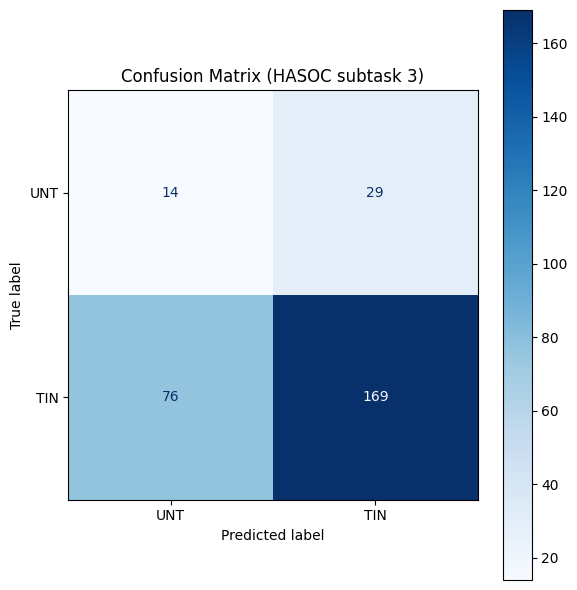

In [104]:
# --- Create test DataLoader or inference loader (unchanged) ---
test_loader = None
inference_only = False

# Defaults in case we never run evaluation
report = "No classification report available."
cm     = []  # empty or [[ ]] 
test_loss = test_acc = test_f1 = test_precision = test_recall = 0.0


if df_test is not None and len(df_test) > 0:
    has_labels = 'label' in df_test.columns
    test_dataset = TextClassificationDataset(
        texts = df_test['clean_text'].tolist(),
        labels= df_test['label'].tolist() if has_labels else None,
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )
    if has_labels:
        print(f"✔️ Built evaluation DataLoader for {len(test_dataset)} labeled test samples.")
    else:
        inference_only = True
        print(f"ℹ️ Built inference DataLoader for {len(test_dataset)} test samples (no labels).")
else:
    print("⚠️ No test data found; skipping test loader.")



# --- Run test set evaluation or inference ---
if test_loader is None:
    print("\nSkipping test set evaluation/inference (no test_loader).")

elif not inference_only:
    # ----- EVALUATION WITH LABELS -----
    print("\nEvaluating on Test Set...")
    test_loss, test_acc, test_f1, test_precision, test_recall, test_labels, test_preds = eval_model(
        model, test_loader, device, loss_fn
    )

    # Print metrics
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Test F1-score:  {test_f1:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall:    {test_recall:.4f}")

    # Build a properly ordered list of (int) labels and their names
    int_labels   = [v for _,v in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
    target_names = [k for k,_ in sorted(LABEL_MAP.items(), key=lambda x: x[1])]

    report = classification_report(
        y_true=test_labels,
        y_pred=test_preds,
        labels=int_labels,          # ensure we include every class
        target_names=target_names,
        digits=4,
        zero_division=0
    )

    print("\nClassification Report:")
    print(report)

    # Confusion matrix display & save
    cm = confusion_matrix(test_labels, test_preds, labels=int_labels)
    disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Confusion Matrix ({DATASET_TYPE} subtask {SUBTASK.upper()})')
    fig.tight_layout()
    
    cm_path = os.path.join(OUTPUT_DIR, f'cm_{DATASET_TYPE}_{SUBTASK}.png')
    fig.savefig(cm_path)
    print(f"Saved confusion matrix to {cm_path}")


elif inference_only:
    # ----- INFERENCE-ONLY, NO TRUE LABELS -----
    print("\nRunning inference on unlabeled Test Set...")
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)

    inv_label_map = {v:k for k,v in LABEL_MAP.items()}
    pred_strs = [inv_label_map[p] for p in all_preds]

    out_df = pd.DataFrame({
        'id':        df_test.get('id', range(len(all_preds))),
        'prediction':    all_preds,
        'prediction_str': pred_strs
    })
    out_path = os.path.join(OUTPUT_DIR,
    f'{DATASET_TYPE}_subtask{SUBTASK.upper()}_predictions.csv')

    out_df.to_csv(out_path, index=False)
    print(f"▶️ Inference done. Saved predictions to {out_path}")

    # No true labels → no report or confusion matrix
    report = "Inference-only mode; no classification report."
    cm     = []

    # How many examples to display
    n_display = 20

    # Get unique predicted class labels (e.g. ['NOT','OFF'])
    pred_classes = out_df['prediction_str'].unique().tolist()
    n_classes = len(pred_classes)
    # Compute how many per class (at least one)
    per_class = max(1, n_display // n_classes)

    # Sample per class
    sampled = (
        out_df
        .groupby('prediction_str', group_keys=False)
        .apply(lambda grp: grp.sample(min(len(grp), per_class), random_state=SEED))
    )

    # If we overshot (e.g. 2 classes × 3 = 6 > 5), just pick n_display at random
    if len(sampled) > n_display:
        sampled = sampled.sample(n_display, random_state=SEED)

    # Finally, shuffle the small sample so it’s not grouped by class
    sampled = sampled.sample(frac=1, random_state=SEED).reset_index(drop=True)

    print("\nSample predictions (balanced across predicted classes):")
    print(sampled)


## 11. Save Artifacts and Results

Save the trained model, tokenizer, training history plots, and final results.


Saving artifacts...
Best model and tokenizer saved to: model_output/best_model
Training history plot saved to model_output/training_history.png
Results saved to model_output/results_HASOC_subtask3.json


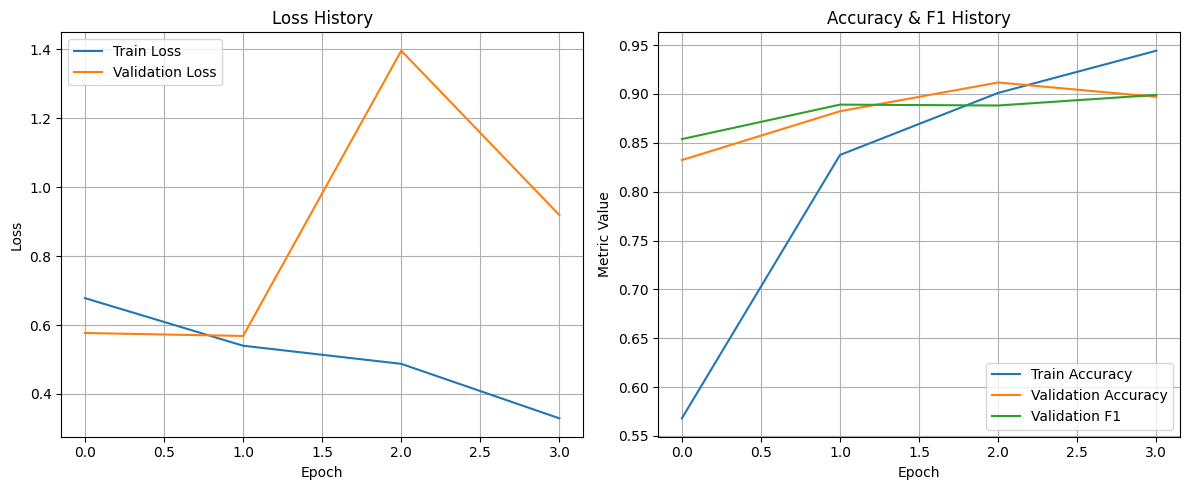

In [105]:
# After saving artifacts

print("\nSaving artifacts...")

# --- Save Model and Tokenizer ---
model_save_path = os.path.join(OUTPUT_DIR, 'best_model')
try:
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f"Best model and tokenizer saved to: {model_save_path}")
except Exception as e:
    print(f"Error saving model or tokenizer: {e}")

# --- Plot Training History ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.plot(history['val_f1'], label='Validation F1')
plt.title('Accuracy & F1 History')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
history_plot_path = os.path.join(OUTPUT_DIR, 'training_history.png')
try:
    plt.savefig(history_plot_path)
    print(f"Training history plot saved to {history_plot_path}")
    # plt.show() # Uncomment to display inline
except Exception as e:
    print(f"Error saving history plot: {e}")

# --- Save Configuration and Results to JSON ---
# Reuse config_dict from earlier
# Ensure confusion_matrix is serializable
cm_data = cm.tolist() if hasattr(cm, 'tolist') else cm

results = {
    'config': config_dict,
    'training_info': {
        'epochs_run': len(history['train_loss']),
        'total_training_time_seconds': total_training_time_seconds,
        'best_validation_loss': best_val_loss if best_model_state is not None else None,
        'best_epoch': best_epoch if best_model_state is not None else None
    },
    'history': history,
    'test_metrics': {
        'loss': test_loss,
        'accuracy': test_acc,
        'f1_score_weighted': test_f1,
        'precision_weighted': test_precision,
        'recall_weighted': test_recall
    },
    'classification_report': report,
    'confusion_matrix': cm_data
}

results_filename = f"results_{DATASET_TYPE}_subtask{SUBTASK.lower()}.json"
results_path     = os.path.join(OUTPUT_DIR, results_filename)

try:
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Results saved to {results_path}")
except Exception as e:
    print(f"Error saving results JSON: {e}")

## 12. Comparing Classification Reports

⚠️  Could not find model_output/results_OffenseEval_subtaska.json, skipping.
⚠️  Could not find model_output/results_OffenseEval_subtaskb.json, skipping.
⚠️  Could not find model_output/results_OffenseEval_subtaskc.json, skipping.


,dataset,subtask,accuracy,f1_weighted
0,HASOC,1,0.806592,0.813764
1,HASOC,2,0.666667,0.630172
2,HASOC,3,0.635417,0.680495


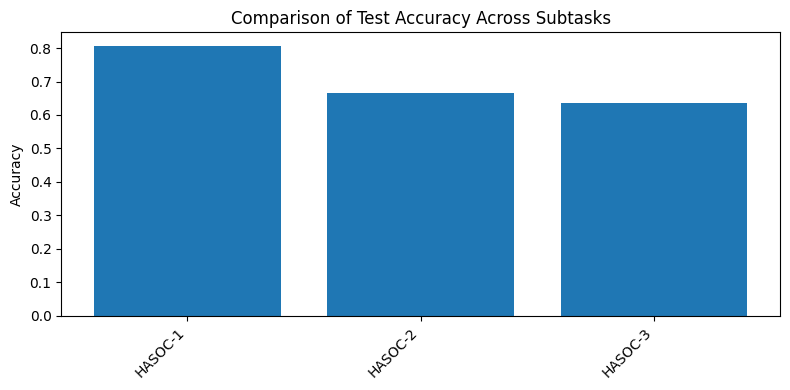

In [106]:

# List the datasets & subtasks you care about
configs = [
    ('HASOC',      '1'),
    ('HASOC',      '2'),
    ('HASOC',      '3'),
    ('OffenseEval','a'),
    ('OffenseEval','b'),
    ('OffenseEval','c'),
]

results = []
for ds, st in configs:
    # load the JSON you saved in each run: results_{DS}_subtask{ST}.json
    fn = f"results_{ds}_subtask{st}.json"
    path = os.path.join(OUTPUT_DIR, fn)
    try:
        with open(path) as f:
            r = json.load(f)
        acc = r['test_metrics']['accuracy']
        f1  = r['test_metrics']['f1_score_weighted']
        results.append({
            'dataset': ds,
            'subtask': st,
            'accuracy': acc,
            'f1_weighted': f1
        })
    except FileNotFoundError:
        print(f"⚠️  Could not find {path}, skipping.")

# Build a DataFrame and display
df = pd.DataFrame(results)
display(df)

plt.figure(figsize=(8,4))
plt.bar(
    [f"{r['dataset']}-{r['subtask']}" for r in results],
    [r['accuracy'] for r in results]
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Comparison of Test Accuracy Across Subtasks")
plt.tight_layout()
plt.show()


## 13. Explainability (Attention Visualization)

 Visualizing attention helps in understanding which parts of the input text the model focuses on when making predictions, thereby offering insights into its decision-making process. We'll use custom plotting functions with matplotlib and seaborn for flexibility and control.

### Helper Function to Extract Attentions and Tokens

This utility function handles the preprocessing of text, tokenization, running the model to get attention weights, and preparing tokens for visualization.

In [107]:
def get_roberta_attentions_and_tokens(
    model: AutoModelForSequenceClassification, 
    tokenizer: AutoTokenizer, 
    text: str, 
    device: torch.device, 
    max_len: int
) -> tuple | None:
    """
    Returns cleaned tokens (no Ġ), corresponding attention matrices, 
    and the preprocessed text.
    """

    # 1) Ensure attentions are enabled
    if not model.config.output_attentions:
        raise ValueError("Model must be loaded with output_attentions=True")

    # 2) Preprocess text
    processed_text = preprocess_text(text)

    # 3) Tokenize & move to device
    inputs = tokenizer(
        processed_text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    ).to(device)

    input_ids      = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # 4) Forward pass to get attentions
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    attentions = outputs.attentions  # tuple per layer

    # 5) Convert and clean tokens
    raw_tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().tolist())
    # Strip the Ġ prefix from _every_ token
    clean_tokens = [tok.lstrip('Ġ') for tok in raw_tokens]

    # 6) Determine effective length (exclude padding)
    effective_len = int(attention_mask[0].sum().item())

    # 7) Slice tokens and attentions to effective length
    tokens_effective = clean_tokens[:effective_len]
    attentions_per_layer = [
        layer[0, :, :effective_len, :effective_len].cpu()
        for layer in attentions
    ]

    return tokens_effective, attentions_per_layer, processed_text

### Custom Plotting Functions

These functions will generate the actual visualizations (2D heatmaps for token-to-token attention and bar charts for [CLS] token attention).

In [108]:
# Cell 3: Custom Plotting Functions for Attention
def plot_attention_heatmap(
    attention_matrix: np.ndarray, 
    x_labels: list, 
    y_labels: list, 
    title: str = "Attention Heatmap",
    figsize_base: tuple = (0.7, 0.5), # Width, height per token
    min_figsize: tuple = (8, 6), # Minimum figure size
    cmap: str = "viridis",
    annot: bool = False # Set to True to show attention scores on the heatmap (for small matrices)
):
    """Plots a 2D attention matrix as a heatmap using Seaborn."""
    num_x_tokens = len(x_labels)
    num_y_tokens = len(y_labels)
    
    fig_width = max(min_figsize[0], num_x_tokens * figsize_base[0])
    fig_height = max(min_figsize[1], num_y_tokens * figsize_base[1])
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    sns.heatmap(attention_matrix, xticklabels=x_labels, yticklabels=y_labels, cmap=cmap, annot=annot, fmt=".2f", ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Attending To (Key)", fontsize=12)
    ax.set_ylabel("Attended From (Query)", fontsize=12)
    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout(pad=0.5)
    return fig


def plot_cls_token_attention_barchart(
    cls_attention_scores: np.ndarray, 
    tokens: list, # Full list of tokens including [CLS]
    tokenizer: AutoTokenizer, # Pass tokenizer to identify CLS token
    title: str = "[CLS] Token Attention to Other Tokens",
    figsize_base_width_per_token: float = 0.6,
    min_fig_width: float = 8,
    fig_height: float = 4
):
    """Plots attention scores from [CLS] token to other tokens as a bar chart."""
    cls_token_str = tokenizer.cls_token
    
    # Exclude [CLS] token itself from the bar chart's x-axis
    plot_tokens = tokens[1:] if tokens and tokens[0] == cls_token_str else tokens
    plot_scores = cls_attention_scores[1:] if tokens and tokens[0] == cls_token_str else cls_attention_scores
    
    if not plot_tokens: 
        print(f"Warning: No tokens to plot for '{title}'. Sequence might be too short or only contain [CLS].")
        return None

    fig_width = max(min_fig_width, len(plot_tokens) * figsize_base_width_per_token)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    ax.bar(plot_tokens, plot_scores, color='skyblue')
    ax.set_xticks(np.arange(len(plot_tokens))) # Ensure all labels are shown
    ax.set_xticklabels(plot_tokens, rotation=75, ha="right", fontsize=10)
    ax.set_ylabel("Average Attention Score from [CLS]")
    ax.set_title(title, fontsize=14)
    plt.tight_layout(pad=0.5)
    return fig

### Main Visualization Workflow Function

This improved function orchestrates the process of getting attentions and calling the plotting functions. It allows selecting layers and heads.

In [109]:
# Cell 4: Main Visualization Workflow Function
def improved_visualize_attention(
    model: AutoModelForSequenceClassification, 
    tokenizer: AutoTokenizer, 
    text: str, 
    device: torch.device, 
    max_len: int,
    layer_to_viz: int = -1,          # Default to last layer (-1 means last, -2 second last etc.)
    head_to_viz: str | int = 'average', # Options: 'average', 'all', or a specific head index (0 to num_heads-1)
    output_dir: str = "model_output", # Directory to save plots
    sample_id: str = "sample",       # Identifier for filenames (e.g., DataFrame index or sample number)
    show_plots: bool = True,         # Whether to display plots inline
    save_plots: bool = True          # Whether to save plots to output_dir
):
    """
    Generates and optionally saves/shows attention visualizations for a given text, layer, and head.
    Produces:
    1. Bar chart of [CLS] token's average attention (across heads) to other tokens for the specified layer.
    2. 2D heatmap(s) of token-to-token attention for the specified layer and head(s).
    """
    os.makedirs(output_dir, exist_ok=True) # Ensure output directory exists

    attention_data = get_roberta_attentions_and_tokens(model, tokenizer, text, device, max_len)
    if attention_data is None:
        print(f"Could not retrieve attention data for sample {sample_id}.")
        return

    tokens, attentions_per_layer, processed_text = attention_data
    
    if not tokens:
        print(f"No tokens returned for sample {sample_id}, cannot visualize.")
        return

    num_layers = len(attentions_per_layer)
    num_heads = attentions_per_layer[0].shape[0] # (num_heads, seq_len, seq_len)

    # Validate and adjust layer_to_viz
    actual_layer_idx = layer_to_viz
    if actual_layer_idx < 0:
        actual_layer_idx = num_layers + actual_layer_idx 
    
    if not (0 <= actual_layer_idx < num_layers):
        print(f"Error: layer_to_viz ({layer_to_viz}, resolved to {actual_layer_idx}) is out of range (0-{num_layers-1}). Defaulting to last layer.")
        actual_layer_idx = num_layers - 1
        
    selected_layer_attentions = attentions_per_layer[actual_layer_idx] # Shape: (num_heads, effective_seq_len, effective_seq_len)

    # --- Plot 1: [CLS] Token Average Attention Bar Chart ---
    # Average attention across all heads for the selected layer
    avg_attention_all_heads_selected_layer = torch.mean(selected_layer_attentions, dim=0).numpy() 
    
    # Find [CLS] token index, default to 0 if not found (should always be there with add_special_tokens=True)
    try:
        cls_idx = tokens.index(tokenizer.cls_token)
    except ValueError:
        print(f"Warning: {tokenizer.cls_token} token not found in tokens list. Assuming index 0 for [CLS] attention.")
        cls_idx = 0
            
    cls_to_others_attention = avg_attention_all_heads_selected_layer[cls_idx, :]
    
    # Optional: Normalize [CLS] attention scores (excluding [CLS] itself)
    # score_sum = np.sum(cls_to_others_attention[cls_idx+1:])
    # if score_sum > 0:
    #    cls_to_others_attention[cls_idx+1:] = cls_to_others_attention[cls_idx+1:] / score_sum

    bar_title = f"[CLS] Avg. Head Attn. (L{actual_layer_idx}) - Sample {sample_id}\nText: \"{text[:40]}...\""
    fig_bar = plot_cls_token_attention_barchart(
        cls_attention_scores=cls_to_others_attention,
        tokens=tokens,
        tokenizer=tokenizer,
        title=bar_title
    )
    if fig_bar:
        if save_plots:
            bar_chart_path = os.path.join(output_dir, f"attn_bar_{sample_id}_L{actual_layer_idx}.png")
            try:
                fig_bar.savefig(bar_chart_path, bbox_inches='tight')
                print(f"Bar chart saved: {bar_chart_path}")
            except Exception as e:
                print(f"Error saving bar chart for sample {sample_id}: {e}")
        if show_plots:
            plt.show()
        plt.close(fig_bar)

    # --- Plot 2: Full Token-to-Token Attention Heatmap(s) ---
    plot_head_indices = []
    if head_to_viz == 'average':
        plot_head_indices.append('average')
    elif head_to_viz == 'all':
        plot_head_indices.extend(range(num_heads))
    elif isinstance(head_to_viz, int) and 0 <= head_to_viz < num_heads:
        plot_head_indices.append(head_to_viz)
    else:
        print(f"Notice: Invalid head_to_viz value: {head_to_viz}. Defaulting to 'average' for heatmap.")
        plot_head_indices.append('average')

    for head_spec in plot_head_indices:
        if head_spec == 'average':
            attention_matrix_for_plot = torch.mean(selected_layer_attentions, dim=0).numpy()
            head_label = "AvgHead"
        else: # Specific head index
            attention_matrix_for_plot = selected_layer_attentions[head_spec, :, :].numpy()
            head_label = f"Head{head_spec}"

        heatmap_title = f"Token-to-Token Attn. (L{actual_layer_idx}, {head_label}) - Sample {sample_id}\nText: \"{text[:40]}...\""
        fig_heatmap = plot_attention_heatmap(
            attention_matrix=attention_matrix_for_plot,
            x_labels=tokens,
            y_labels=tokens,
            title=heatmap_title
        )
        if fig_heatmap:
            if save_plots:
                heatmap_filename = f"attn_heatmap_{sample_id}_L{actual_layer_idx}_{head_label}.png"
                heatmap_path = os.path.join(output_dir, heatmap_filename)
                try:
                    fig_heatmap.savefig(heatmap_path, bbox_inches='tight')
                    print(f"Heatmap saved: {heatmap_path}")
                except Exception as e:
                    print(f"Error saving heatmap for L{actual_layer_idx}, {head_label} (Sample {sample_id}): {e}")
            if show_plots:
                plt.show()
            plt.close(fig_heatmap)
            
    print(f"Finished visualization for sample {sample_id}.")

### Run Visualization Workflow
This cell reloads the best-performing model model with `output_attentions=True` and then iterates through a few samples from the test set to generate and display/save the visualizations.


Reloading model from model_output/best_model for attention visualization...
Model reloaded successfully for visualization.

--- Visualizing Sample 1 (DataFrame Index: 45) ---
Text: dr. qanta ahmed rep. omar is a disgrace to islam httpurl via @user...
True Label: TIN (1)
Predicted Label: TIN (1)
Bar chart saved: model_output/attn_bar_df_idx_45_L11.png


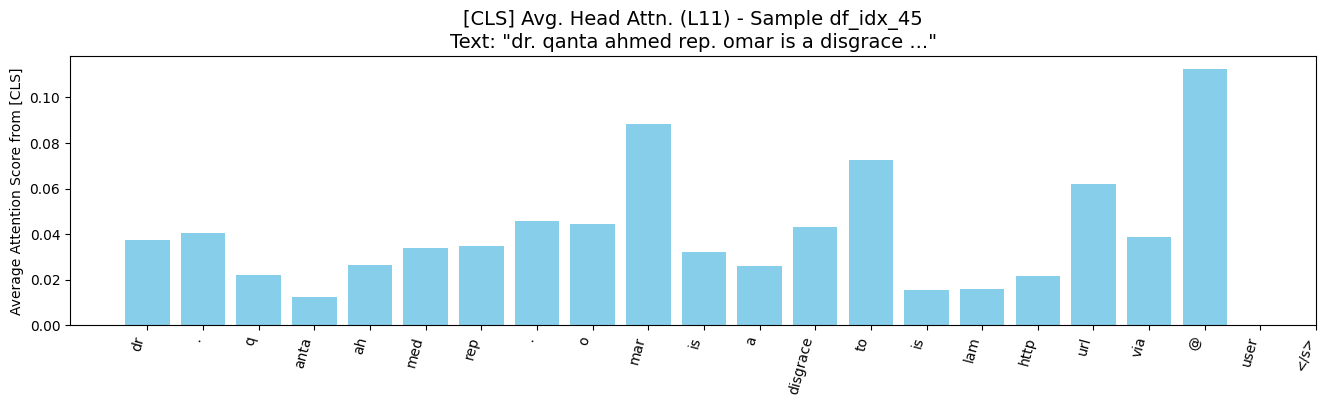

Heatmap saved: model_output/attn_heatmap_df_idx_45_L11_AvgHead.png


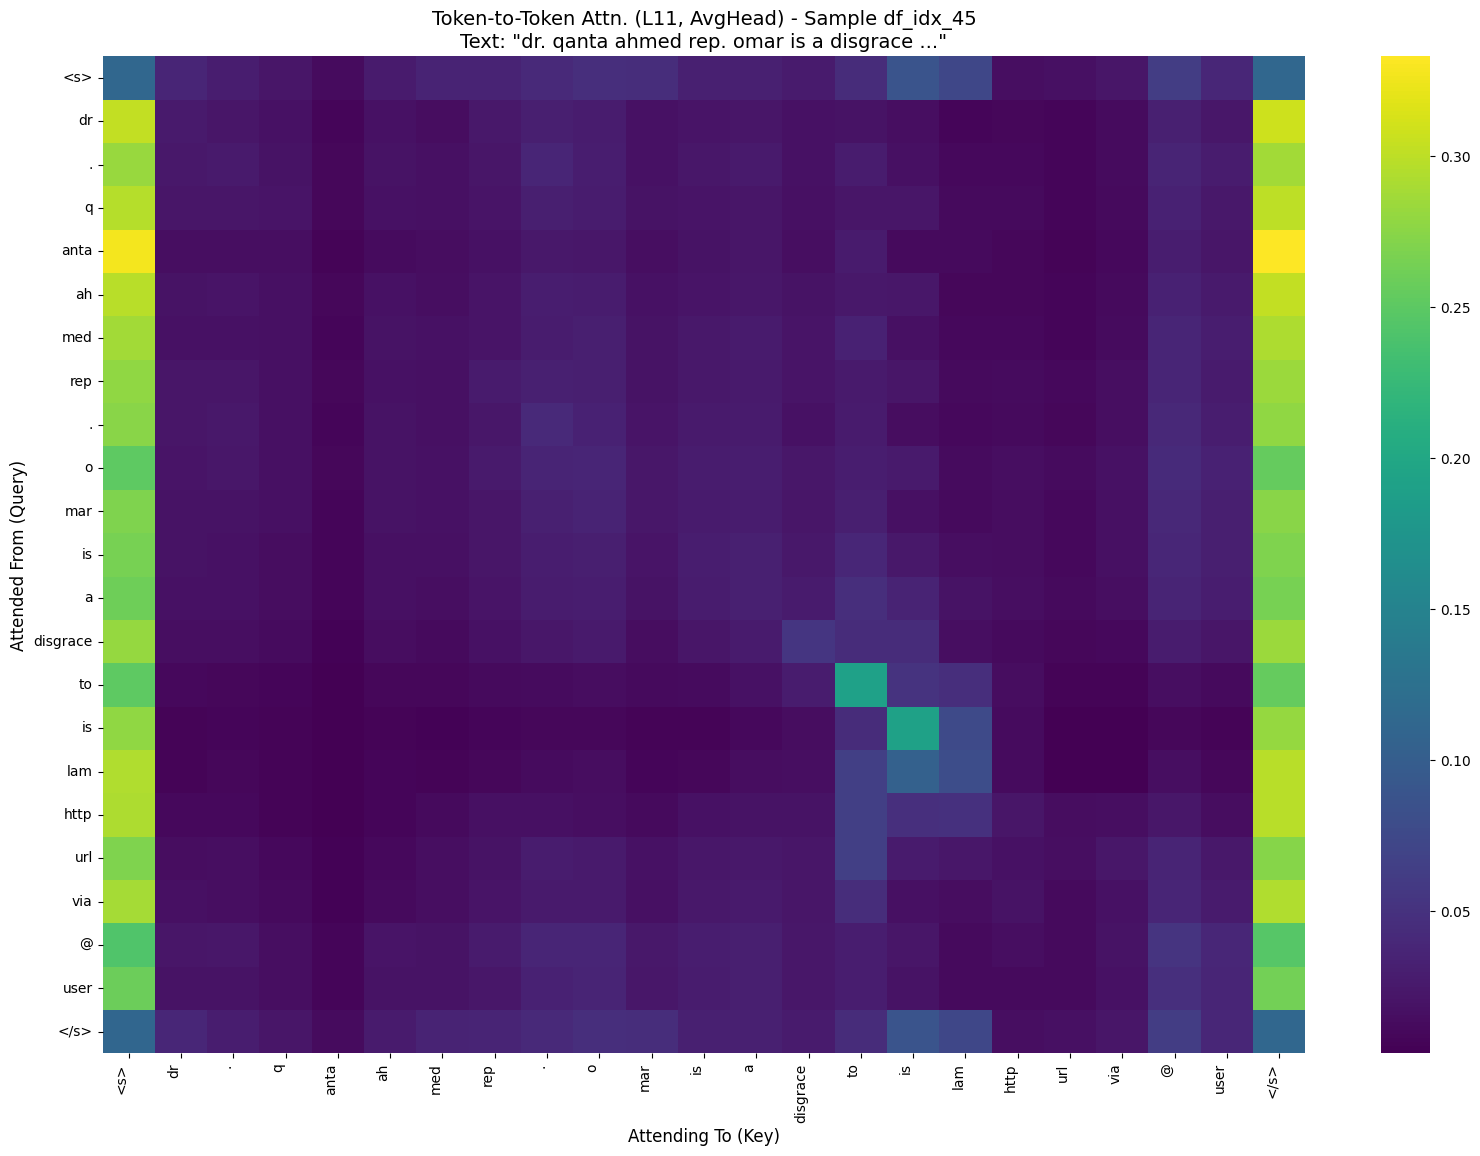

Finished visualization for sample df_idx_45.

--- Visualizing Sample 2 (DataFrame Index: 157) ---
Text: good. btw the majority of northern irish voted to remain in the eu. why should they follow an english prime minister who has no democratic legitimacy to continue pursuing the failed brexit project? st...
True Label: TIN (1)
Predicted Label: UNT (0)
Bar chart saved: model_output/attn_bar_df_idx_157_L11.png


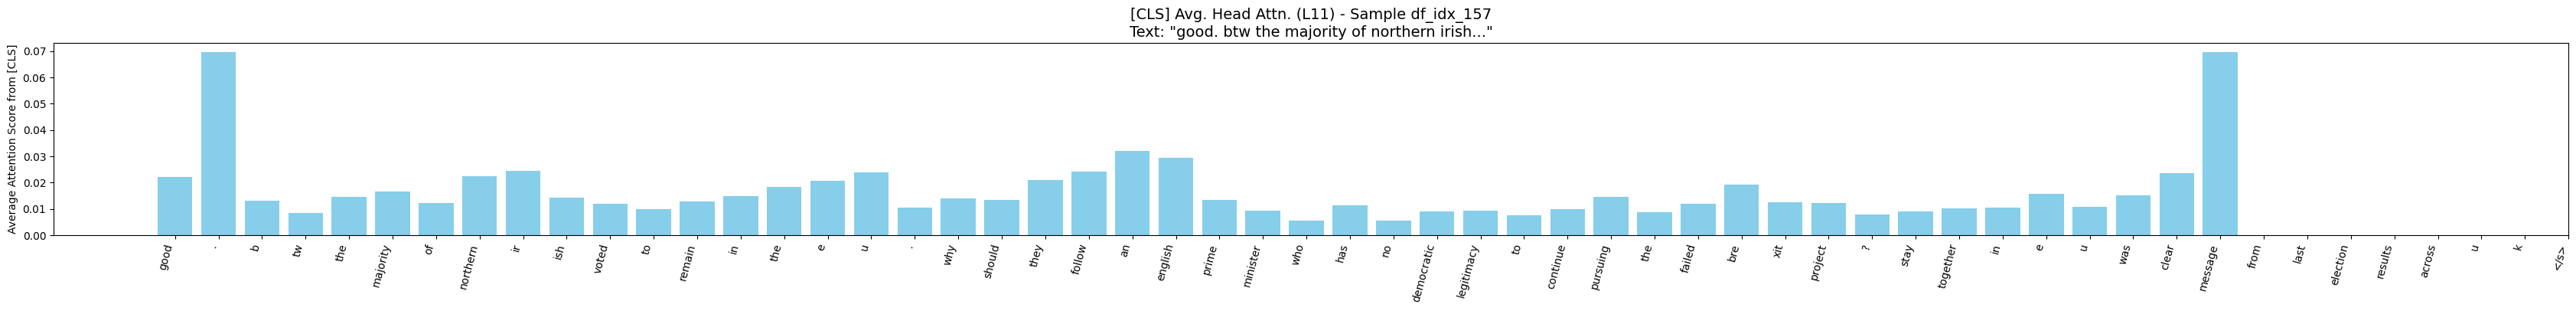

Heatmap saved: model_output/attn_heatmap_df_idx_157_L11_AvgHead.png


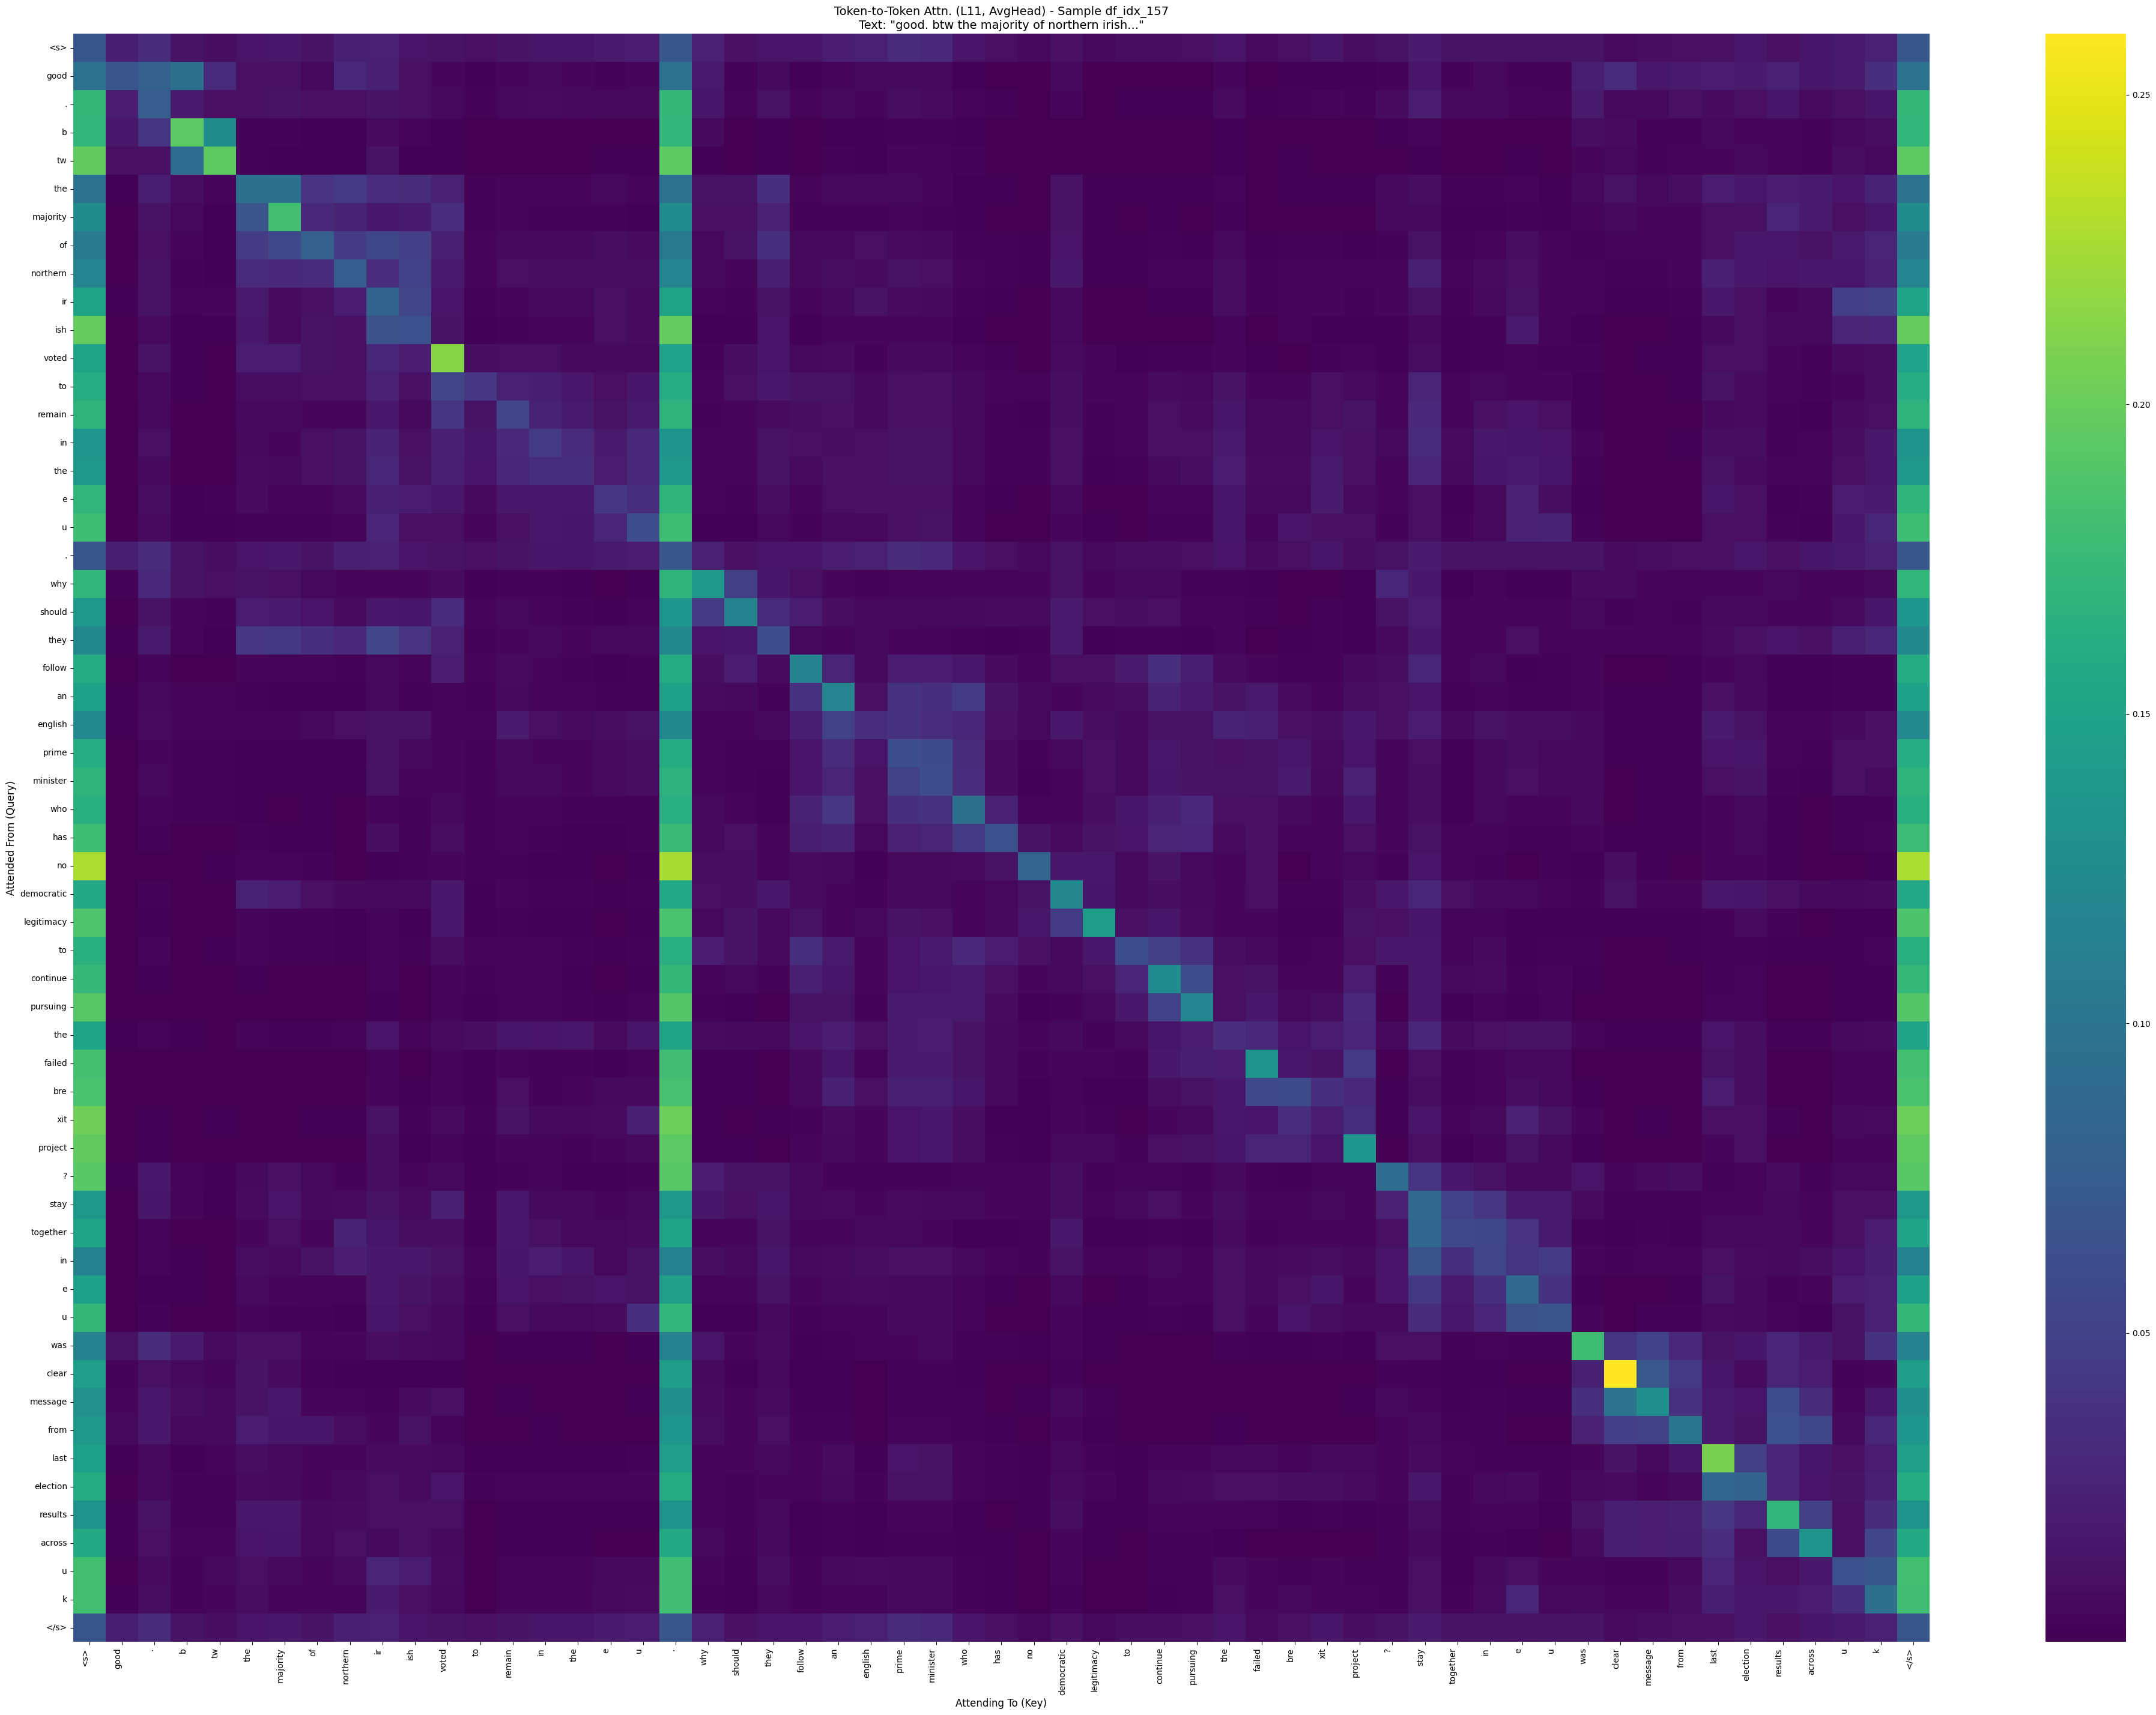

Finished visualization for sample df_idx_157.

--- Visualizing Sample 3 (DataFrame Index: 256) ---
Text: people like pandit amit are making me go farther away from hinduism and closer to atheism. btw i have already distanced myself from the bjp that i once supported because of such chutiyes. istandwitham...
True Label: TIN (1)
Predicted Label: TIN (1)
Bar chart saved: model_output/attn_bar_df_idx_256_L11.png


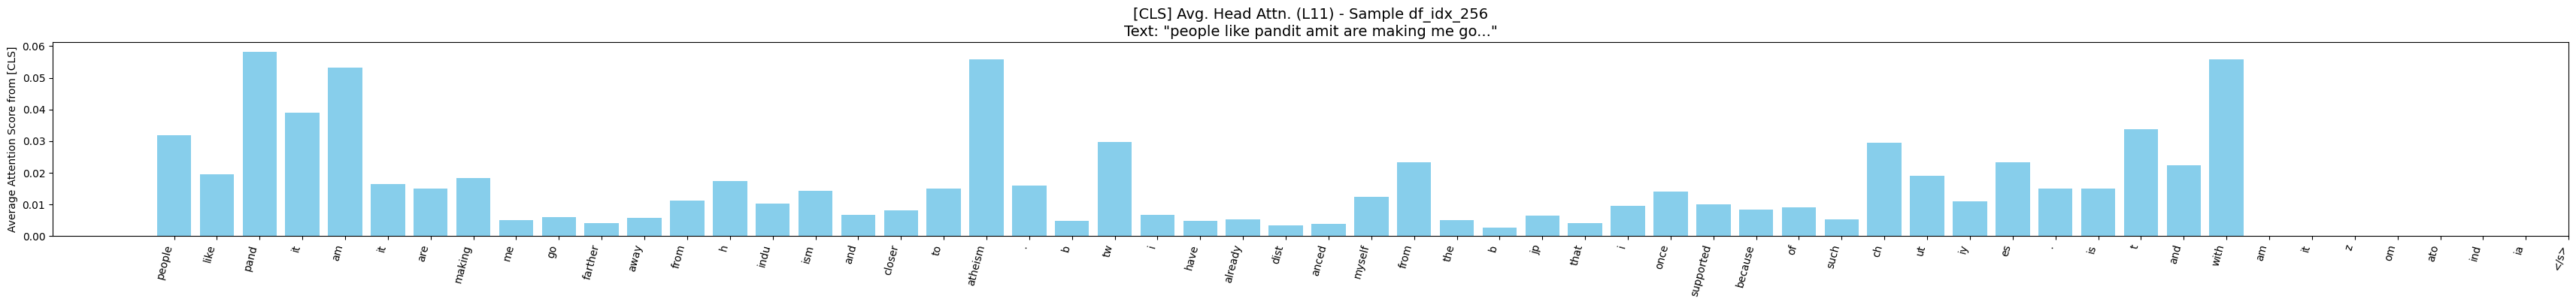

Heatmap saved: model_output/attn_heatmap_df_idx_256_L11_AvgHead.png


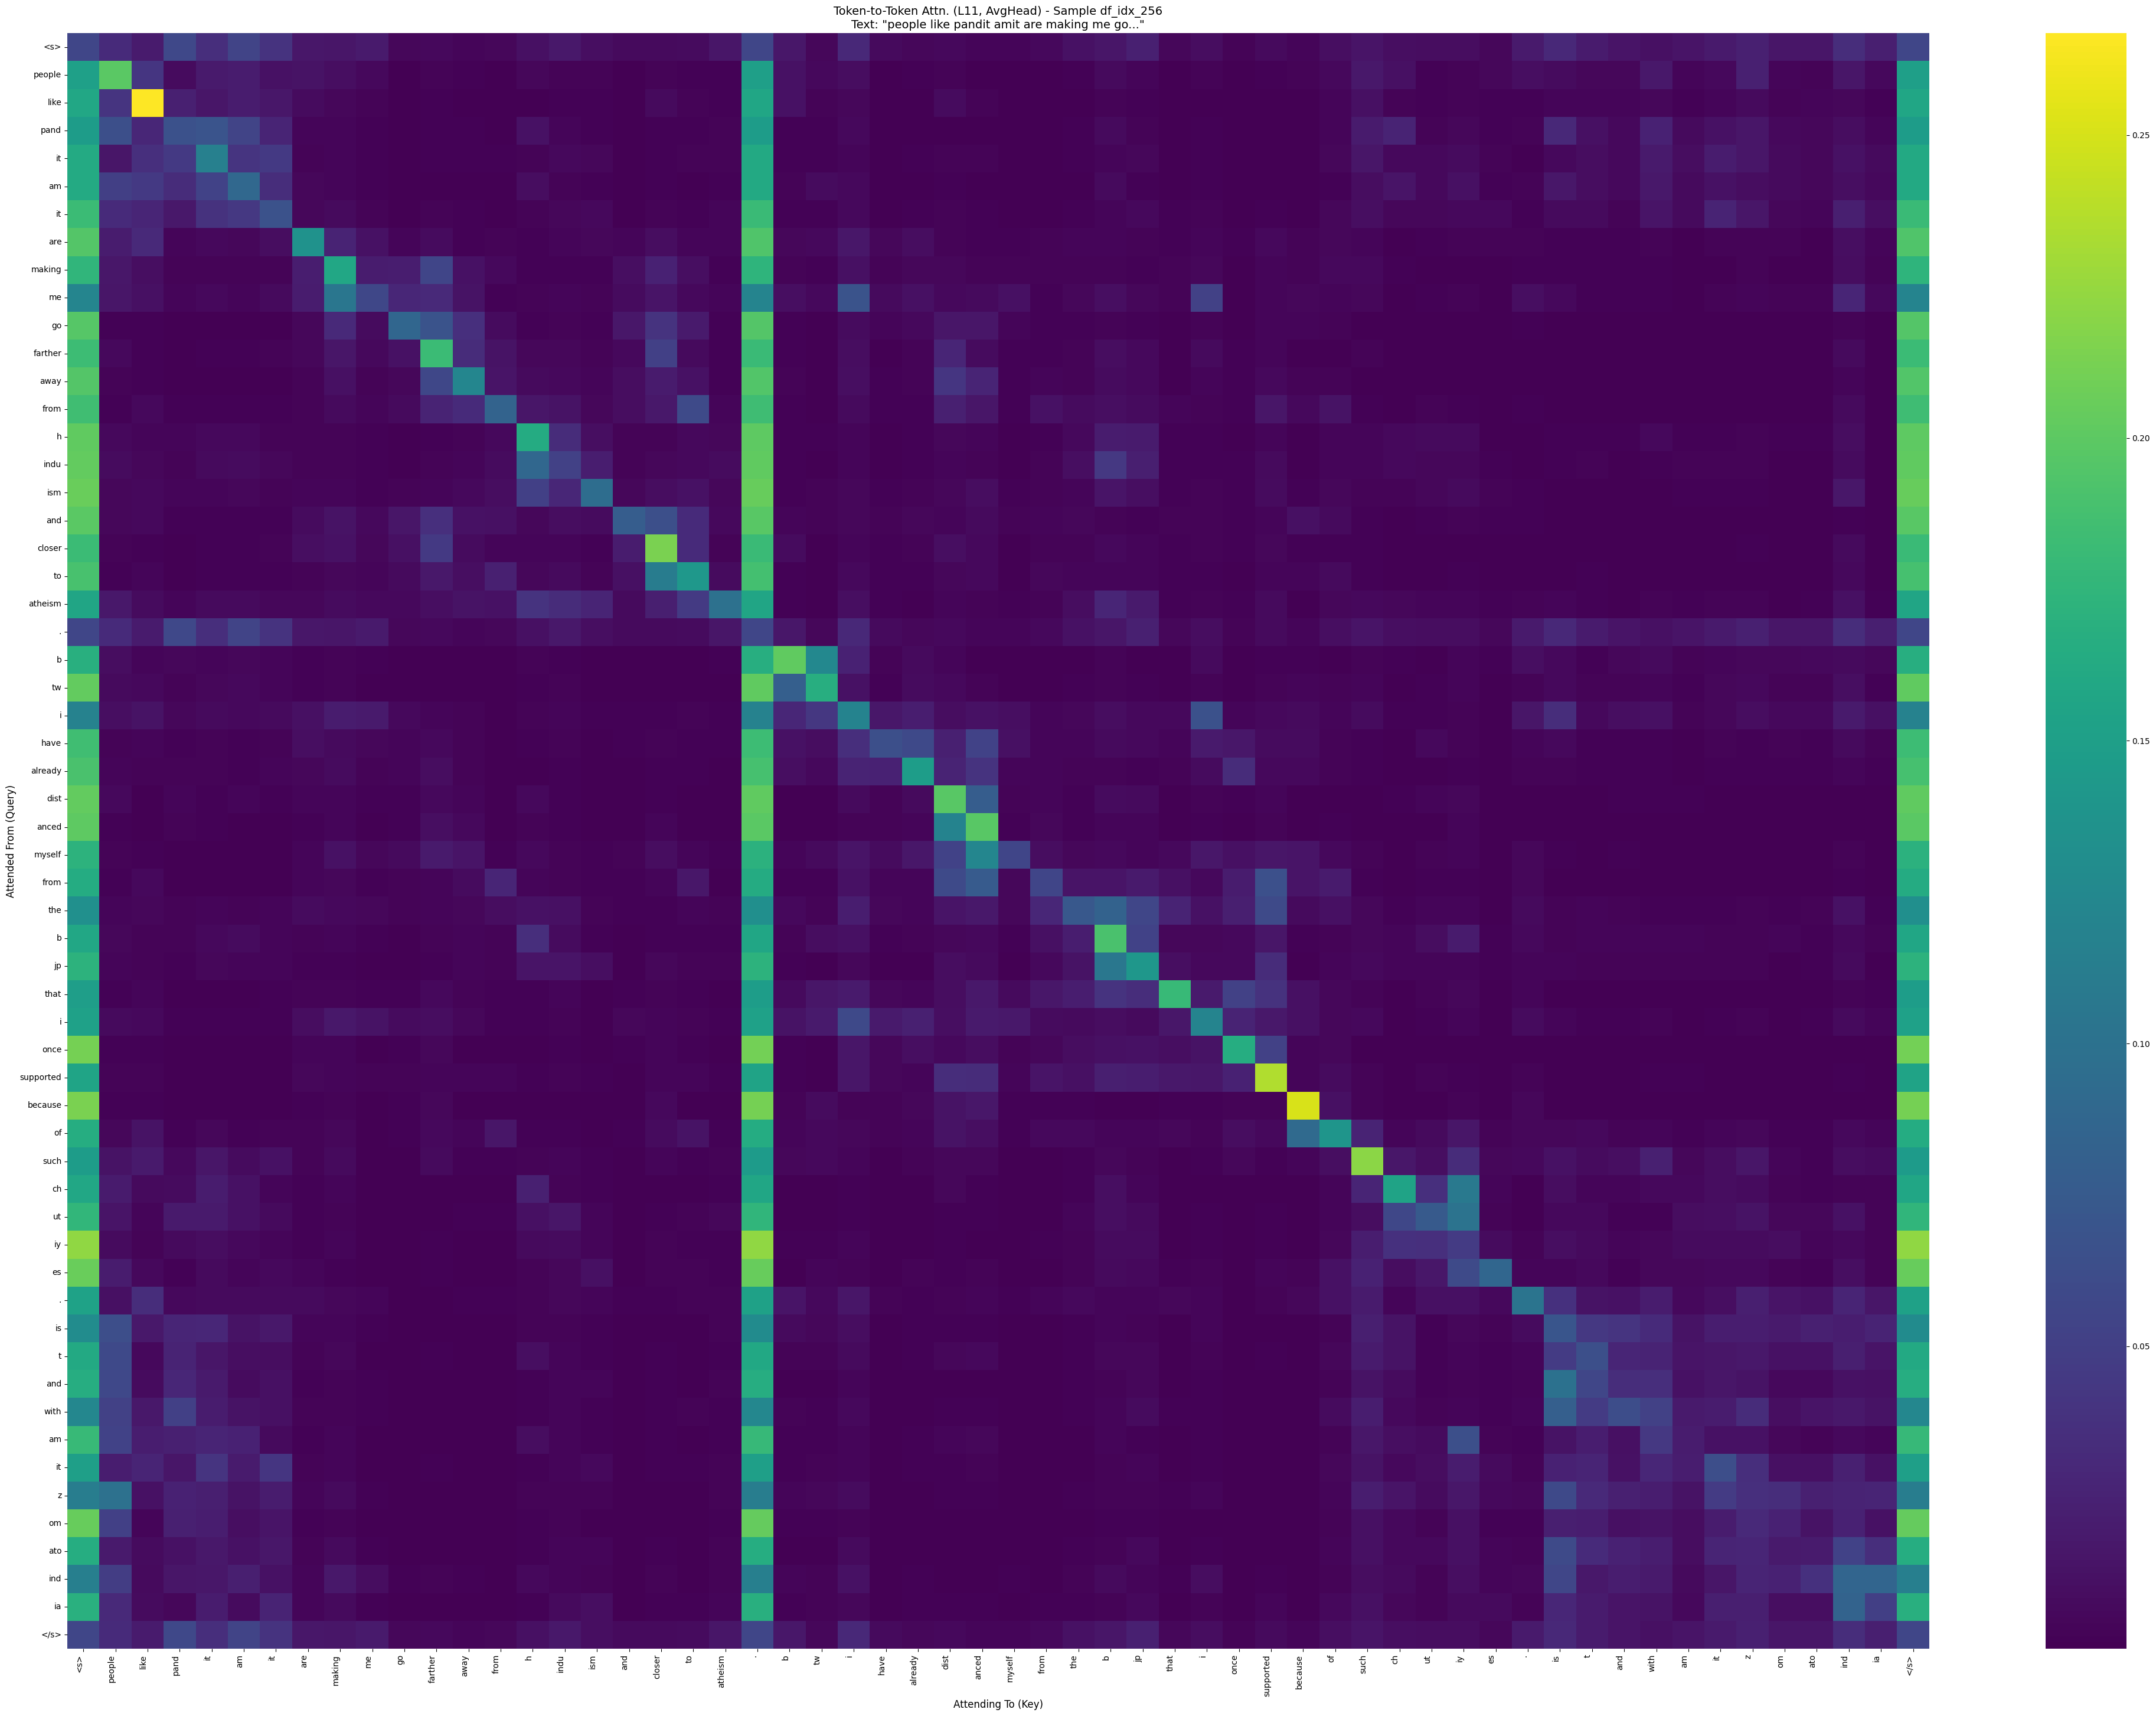

Finished visualization for sample df_idx_256.

--- Visualizing Sample 4 (DataFrame Index: 42) ---
Text: fuck the ucl bring me the icc trophy!!...
True Label: TIN (1)
Predicted Label: TIN (1)
Bar chart saved: model_output/attn_bar_df_idx_42_L11.png


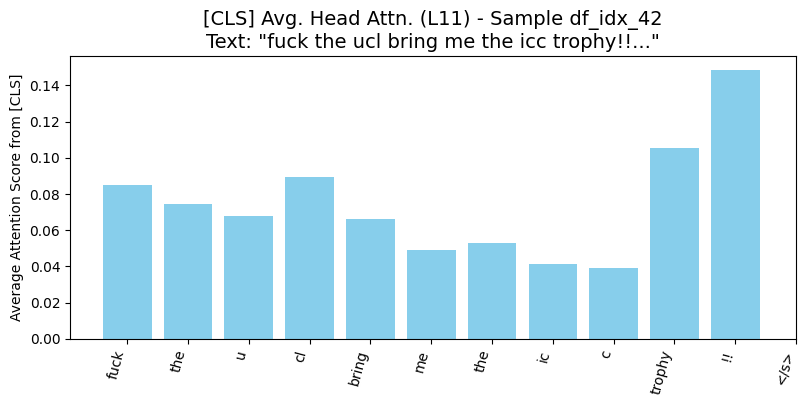

Heatmap saved: model_output/attn_heatmap_df_idx_42_L11_AvgHead.png


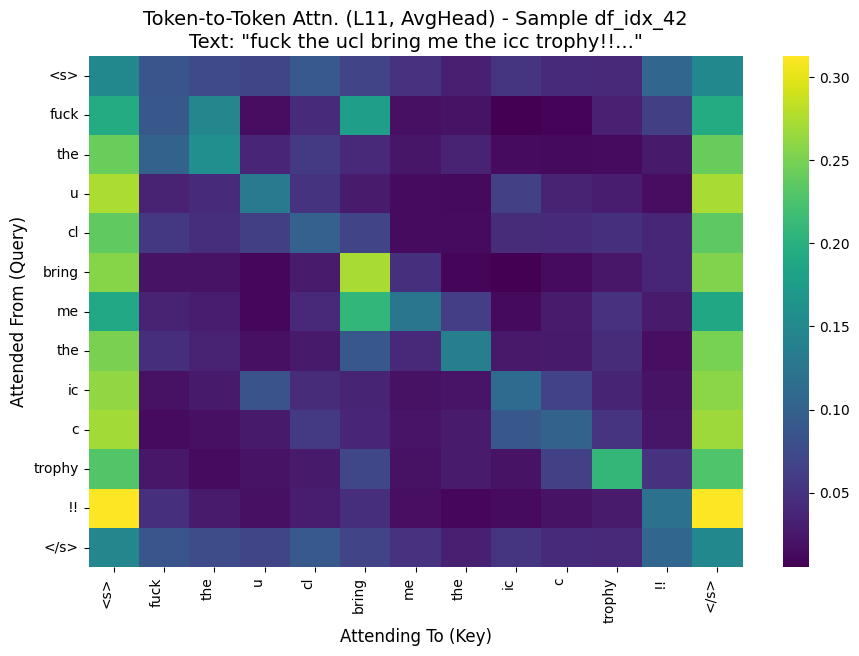

Finished visualization for sample df_idx_42.

--- Visualizing Sample 5 (DataFrame Index: 181) ---
Text: man, what the fuck. these people in your building are disgusting. i’m sorry that you have to put up with that. it’s outrageous. all of these people should be kicked out...
True Label: TIN (1)
Predicted Label: UNT (0)
Bar chart saved: model_output/attn_bar_df_idx_181_L11.png


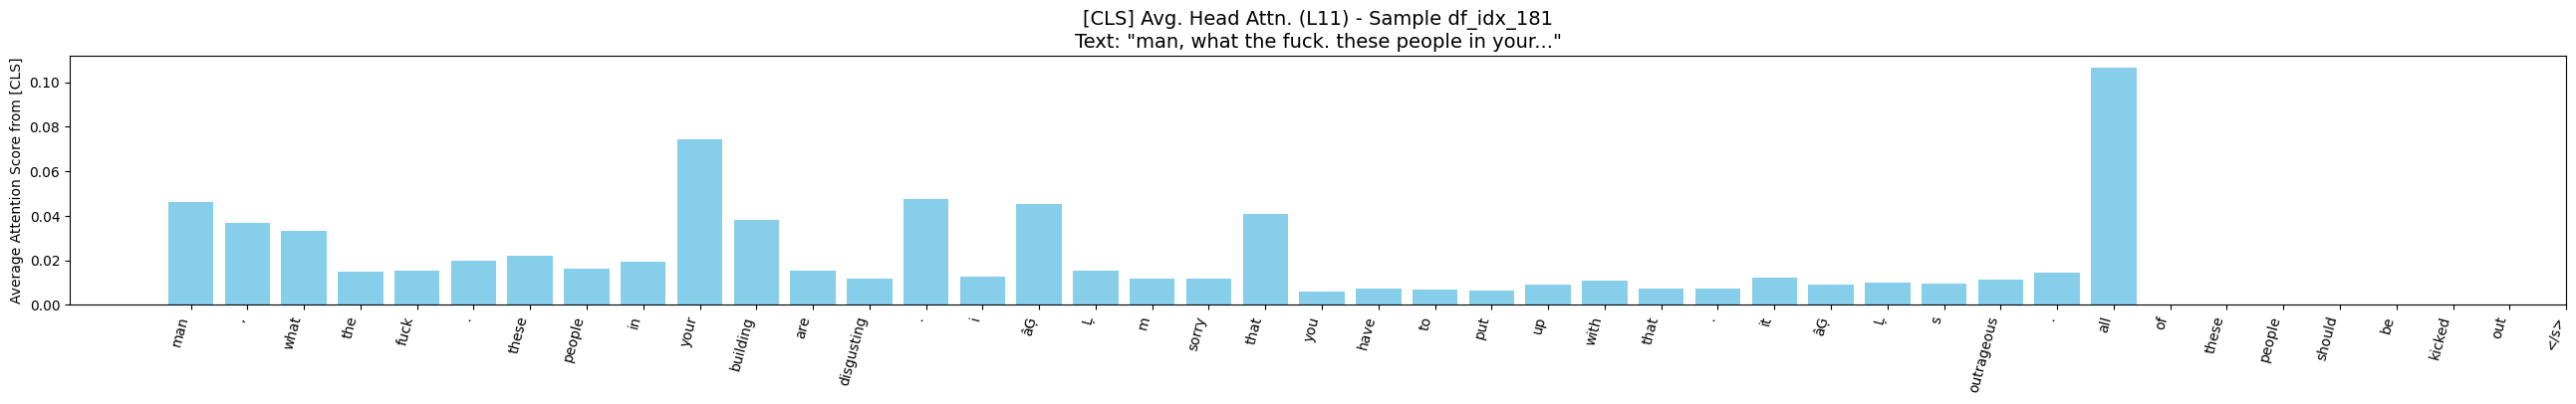

Heatmap saved: model_output/attn_heatmap_df_idx_181_L11_AvgHead.png


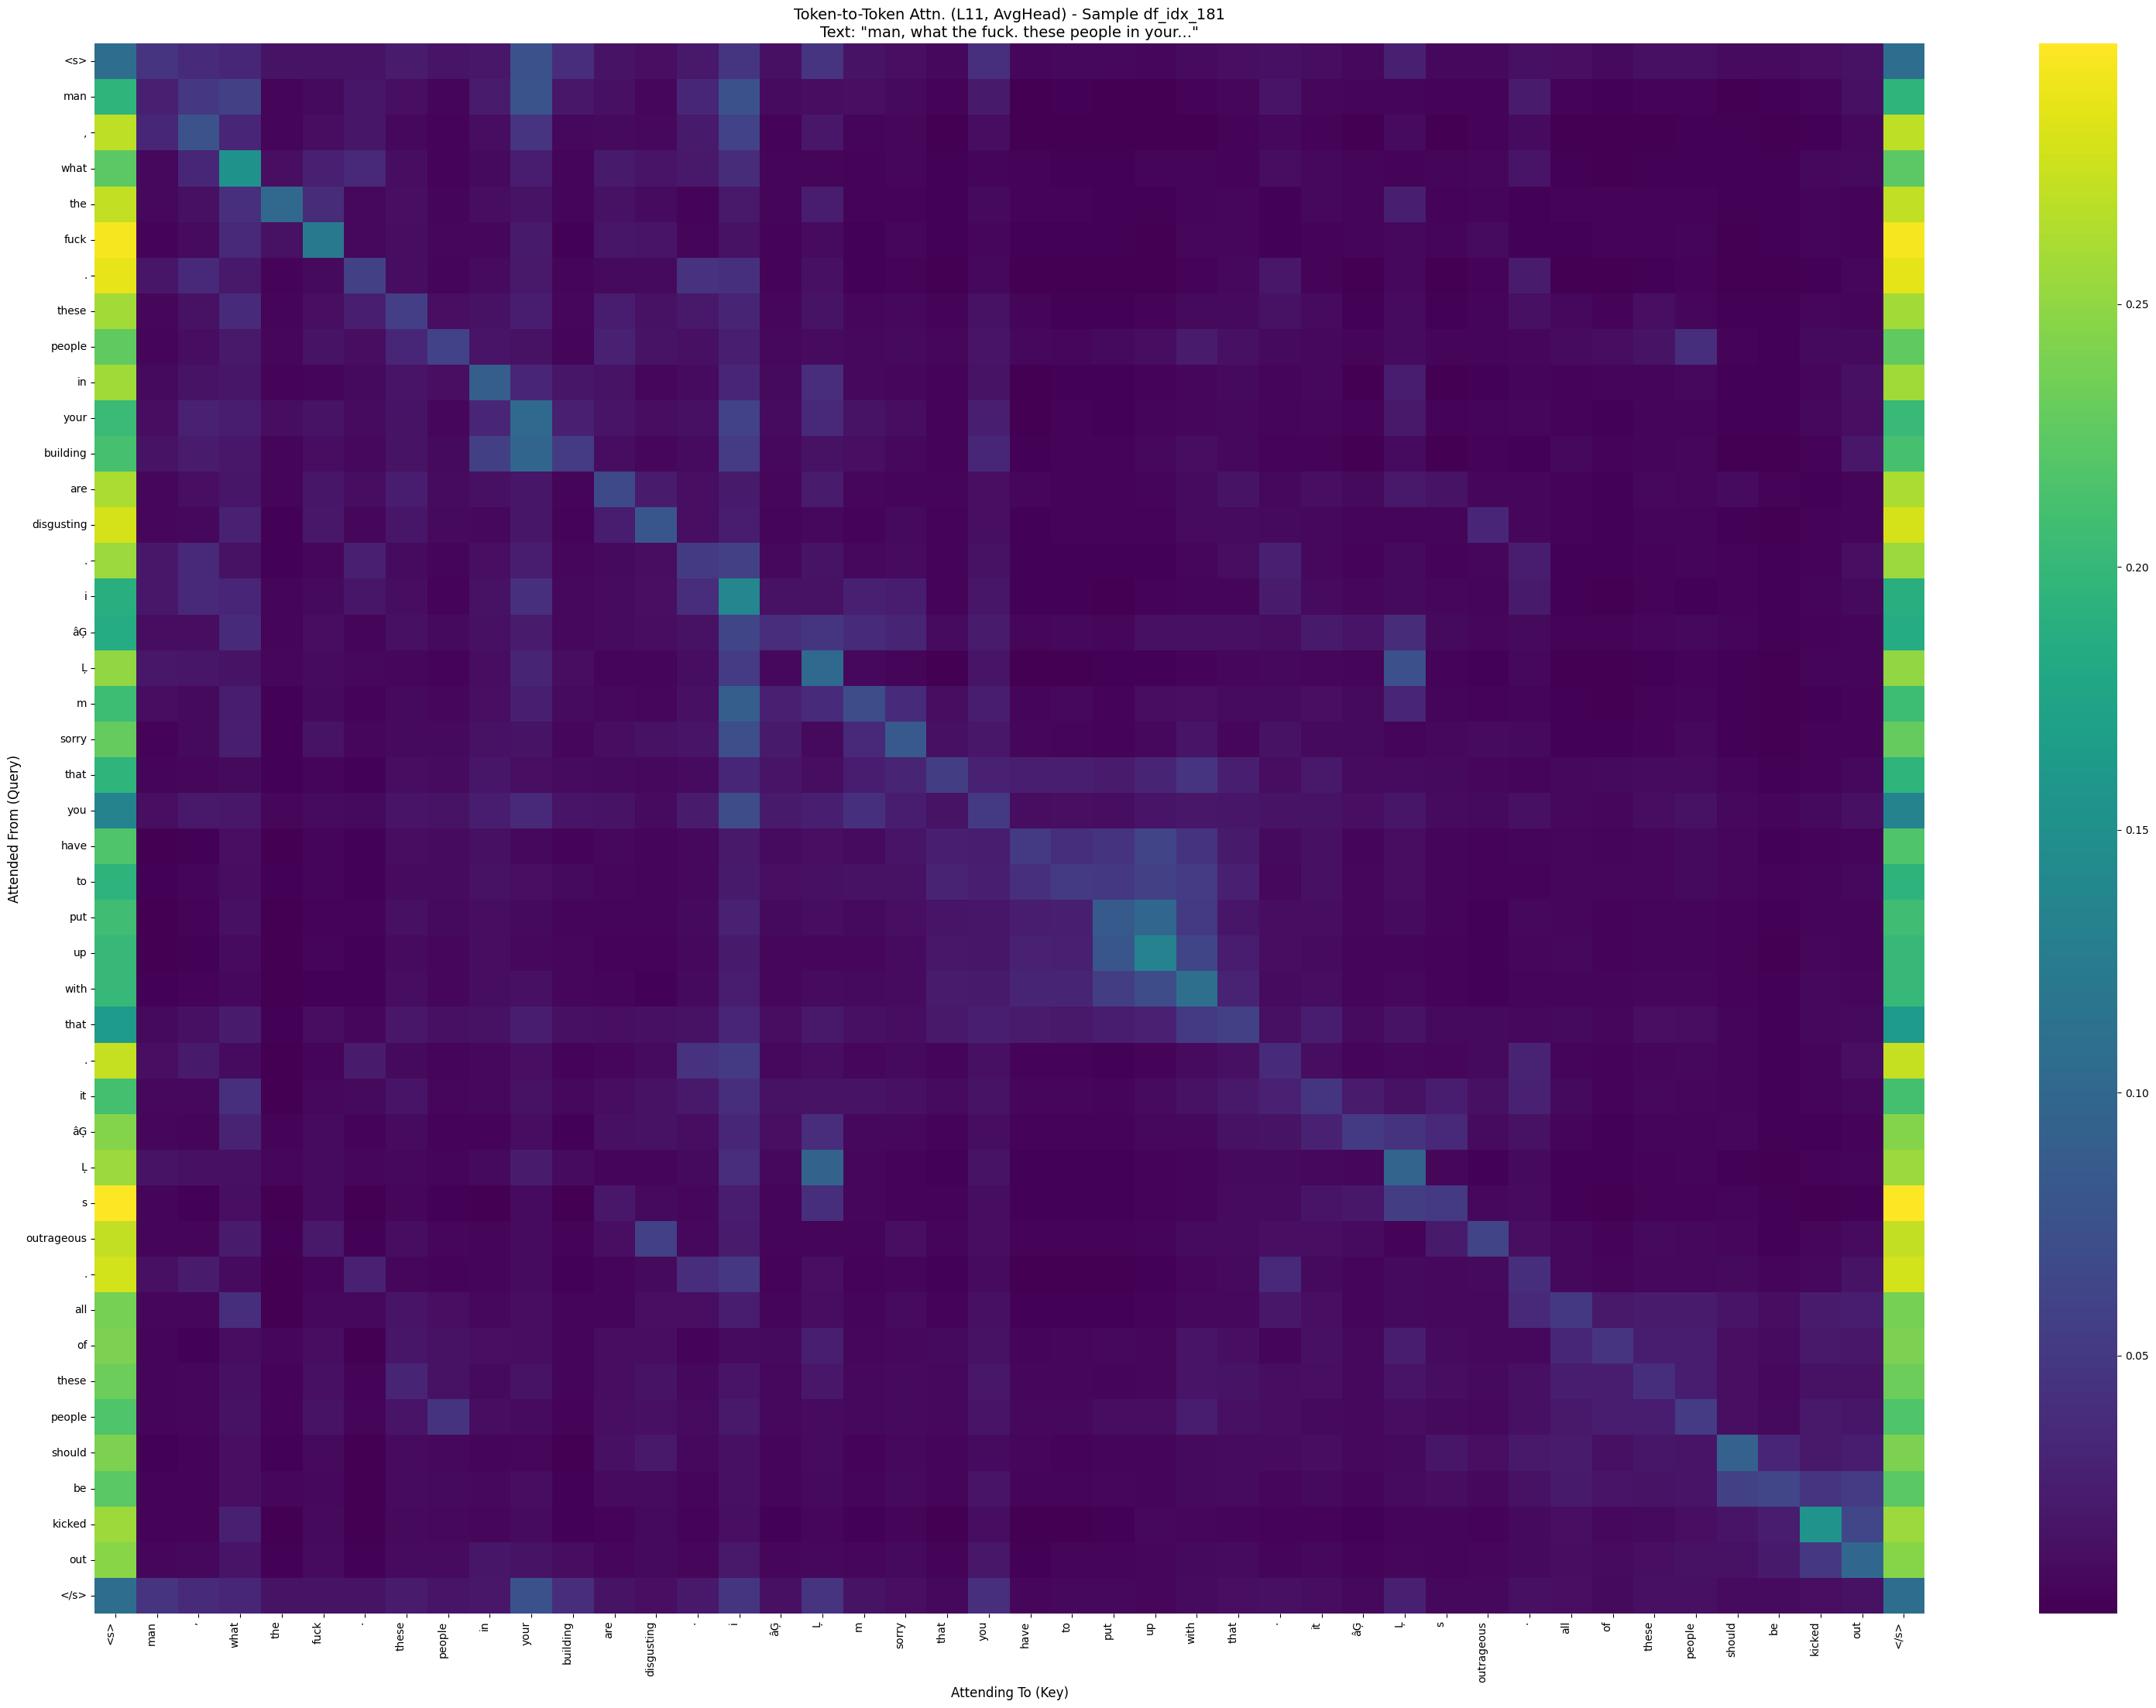

Finished visualization for sample df_idx_181.


In [110]:
# Cell 5: Reload Model and Run Visualization Workflow

# --- Path to the saved best model ---
model_save_path = os.path.join(OUTPUT_DIR, 'best_model') 

model_for_viz = None # Initialize
if os.path.exists(model_save_path):
    print(f"\nReloading model from {model_save_path} for attention visualization...")
    try:
        model_for_viz = AutoModelForSequenceClassification.from_pretrained(
            model_save_path, 
            output_attentions=True # CRITICAL: Ensure attentions are output
        )
        model_for_viz.to(device)
        model_for_viz.eval() # Set to evaluation mode
        print("Model reloaded successfully for visualization.")
    except Exception as e:
        print(f"Error reloading model for visualization: {e}")
        print("Please ensure the model was saved correctly and the path is accurate.")
else:
    print(f"Error: Saved model not found at {model_save_path}. Cannot perform attention visualization.")

# --- Visualize for a few samples if model loaded and test data available ---
if model_for_viz and 'df_test' in locals() and df_test is not None and not df_test.empty:
    # Get label names from LABEL_MAP for printing (ensure LABEL_MAP is defined)
    try:
        target_names = [k for k, v in sorted(LABEL_MAP.items(), key=lambda item: item[1])]
    except NameError:
        print("Warning: LABEL_MAP not found. True/Predicted labels won't be human-readable.")
        target_names = None


    num_samples_to_viz = 5 # Visualize for 5 samples
    if len(df_test) < num_samples_to_viz:
        print(f"Warning: Test set has fewer than {num_samples_to_viz} samples. Visualizing all available.")
        num_samples_to_viz = len(df_test)

    if num_samples_to_viz > 0:
        # Ensure SEED is defined for reproducible sampling
        try: _ = SEED 
        except NameError: SEED = 42 
        
        sample_indices = df_test.sample(n=num_samples_to_viz, random_state=SEED).index

        for i, data_idx in enumerate(sample_indices):
            original_text = df_test.loc[data_idx, 'clean_text'] # Use your preprocessed text column

            # --- Get True Label (if available) ---
            true_label_str = "N/A"
            if 'label' in df_test.columns and target_names:
                true_label_int = df_test.loc[data_idx, 'label']
                try:
                    true_label_str = f"{target_names[true_label_int]} ({true_label_int})"
                except IndexError:
                    true_label_str = f"Unknown ({true_label_int})"
            
            # --- Get Predicted Label ---
            pred_inputs = tokenizer.encode_plus(original_text, return_tensors='pt', max_length=MAX_LEN, padding='max_length', truncation=True).to(device)
            with torch.no_grad():
                pred_outputs = model_for_viz(input_ids=pred_inputs['input_ids'], attention_mask=pred_inputs['attention_mask'])
            pred_label_int = torch.argmax(pred_outputs.logits, dim=1).item()
            pred_label_str = "N/A"
            if target_names:
                try:
                    pred_label_str = f"{target_names[pred_label_int]} ({pred_label_int})"
                except IndexError:
                    pred_label_str = f"Unknown ({pred_label_int})"

            print(f"\n--- Visualizing Sample {i+1} (DataFrame Index: {data_idx}) ---")
            print(f"Text: {original_text[:200]}...") # Print a snippet
            print(f"True Label: {true_label_str}")
            print(f"Predicted Label: {pred_label_str}")

            improved_visualize_attention(
                model=model_for_viz,
                tokenizer=tokenizer,
                text=original_text,
                device=device,
                max_len=MAX_LEN, # Ensure MAX_LEN is defined
                layer_to_viz=-1,       # Last layer
                head_to_viz='average', # Average across heads for the 2D heatmap
                                       # Try also: head_to_viz=0 (for head 0) or head_to_viz='all' (for all heads)
                output_dir=OUTPUT_DIR, # Ensure OUTPUT_DIR is defined
                sample_id=f"df_idx_{data_idx}",
                show_plots=True,
                save_plots=True
            )
    else:
        print("No samples in df_test to visualize.")
elif not model_for_viz:
    print("Skipping attention visualization as model_for_viz could not be loaded.")
else:
    print("Skipping attention visualization as test data (df_test) is not available or is empty.")